# CAISO Energy Storage Bid Analysis

<b>Author:</b> Neal Ma

<b>Date created:</b> October 15, 2024

<b>Description:</b> This notebook contains final visualization and statistical analyses for CAISO energy storage bids from July 1, 2023 - October 1, 2024. 

CAISO Energy Storage Daily Reports: https://www.caiso.com/library/daily-energy-storage-reports

LCG Consulting Day-Ahead CAISO Prices: http://www.energyonline.com/Data/GenericData.aspx?DataId=22&CAISO___Day-Ahead_Price

LCG Consulting Real-Time CAISO Prices: http://www.energyonline.com/Data/GenericData.aspx?DataId=19


## Primary Analysis

### Notebook Setup and Data Preprocessing

In [51]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import matplotlib.dates as mdates
import math
from scipy.stats import ks_2samp
import os
from matplotlib.dates import DateFormatter


# enable tex for graphs
matplotlib.rc("text", usetex=True)
matplotlib.rc("font", family="serif")

In [52]:
# read energy storage data
ES_df = pd.read_parquet("./data/ES_BIDS/CAISO_ES_BIDS.parquet")


# read real-time price data
RT_df = pd.read_csv("./data/CAISO_RTP.csv")
RT_df["Date"] = pd.to_datetime(RT_df["Date"], format="%m/%d/%Y %I:%M:%S %p")
RT_df = RT_df.drop_duplicates(subset=["Date", "hub"])
RT_df = RT_df.pivot(index="Date", columns="hub", values="price")


# read day-ahead price data
dap_csv_dir = "./data/DAP_CSV/"

# List to hold dataframes
dap_dfs = []

# Read each CSV file and append to the list
for file_name in os.listdir(dap_csv_dir):
    if file_name.endswith(".csv"):
        file_path = os.path.join(dap_csv_dir, file_name)
        dap_dfs.append(pd.read_csv(file_path))

# Concatenate all dataframes
combined_dap_df = pd.concat(dap_dfs)

# Write the combined dataframe to a single CSV file
combined_dap_df.to_csv("./data/CAISO_DAP.csv", index=False)
DA_df = pd.read_csv("./data/CAISO_DAP.csv")
DA_df["Date"] = pd.to_datetime(DA_df["Date"], format="%m/%d/%Y %I:%M:%S %p")
DA_df = DA_df.drop_duplicates(subset=["Date", "zone"])
DA_df = DA_df.pivot(index="Date", columns="zone", values="price")

In [53]:
# merge dataframes
full_df = ES_df.join(RT_df, how="outer")
full_df = full_df.join(DA_df, how="outer")

# filter for data between July 1, 2023 and October 1, 2024
full_df = full_df[
    (full_df.index >= pd.Timestamp("July 1, 2023"))
    & (full_df.index <= pd.Timestamp("October 1, 2024"))
]

# define hub and zones
hubs = ["TH_NP15", "TH_SP15", "TH_ZP26"]
zones = ["PGAE", "SCE", "SDGE", "VEA"]

# track min, max, avg real-time prices for all timestamps
full_df["rt_price_max"] = full_df[hubs].max(axis=1)
full_df["rt_price_min"] = full_df[hubs].min(axis=1)
full_df["rt_price_avg"] = full_df[hubs].mean(axis=1)

# track min, max, avg day-ahead prices for all timestamps
full_df["da_price_max"] = full_df[zones].max(axis=1)
full_df["da_price_min"] = full_df[zones].min(axis=1)
full_df["da_price_avg"] = full_df[zones].mean(axis=1)

In [54]:
bid_segments = {
    "ss": "Self Schedule",
    "1": "[-150, -100]",
    "2": "(-100, -50]",
    "3": "(-50, -15]",
    "4": "(-15, 0]",
    "5": "(0, 15]",
    "6": "(15, 50]",
    "7": "(50, 100]",
    "8": "(100, 200]",
    "9": "(200, 500]",
    "10": "(500, 1000]",
    "11": "(1000, 2000]",
}

bid_segment_edges = [-150, -100, -50, -15, 0, 15, 50, 100, 200, 500, 1000, 2000]
bid_segment_weights = [
    (bid_segment_edges[i] + bid_segment_edges[i + 1]) / 2.0
    for i in range(len(bid_segment_edges) - 1)
]


def add_prop_weighted_columns(data: pd.DataFrame = None, exclude_ss: bool = True):
    bid_columns = [col for col in data.columns if "bid" in col]
    if exclude_ss:
        bid_columns = [col for col in bid_columns if "ss" not in col]

    bid_types = ["rtpd_neg", "rtpd_pos", "ifm_neg", "ifm_pos"]
    for type in bid_types:
        data[f"bid_{type}_tot"] = sum([data[col] for col in bid_columns if type in col])
        type_cols = [col for col in bid_columns if type in col]
        for col in type_cols:
            data[f"{col}_prop"] = data[col] / data[f"bid_{type}_tot"]

        prop_cols = [f"bid_{type}_{val + 1}_prop" for val in range(11)]
        data[f"bid_{type}_weighted"] = np.dot(data[prop_cols], bid_segment_weights)

    data["bid_rtpd_weighted_spread"] = (
        data["bid_rtpd_pos_weighted"] - data["bid_rtpd_neg_weighted"]
    )

    data["bid_ifm_weighted_spread"] = (
        data["bid_ifm_pos_weighted"] - data["bid_ifm_neg_weighted"]
    )

    return data

In [55]:
# load optimal bids
optimal_bids = pd.read_csv("./data/optimal_bids.csv")

# set datetime index
optimal_bids["Unnamed: 0"] = pd.to_datetime(optimal_bids["Unnamed: 0"])
optimal_bids.set_index("Unnamed: 0", inplace=True)
optimal_bids.index.name = "timestamp"

In [56]:
# build daily aggregations (mean)
daily_df = full_df.resample("D").mean()
hourly_df = full_df.resample("h").mean()

full_df = add_prop_weighted_columns(data=full_df, exclude_ss=True)
daily_df = add_prop_weighted_columns(data=daily_df, exclude_ss=True)
hourly_df = add_prop_weighted_columns(data=hourly_df, exclude_ss=True)

### Hour-of-Day Bid Distributions

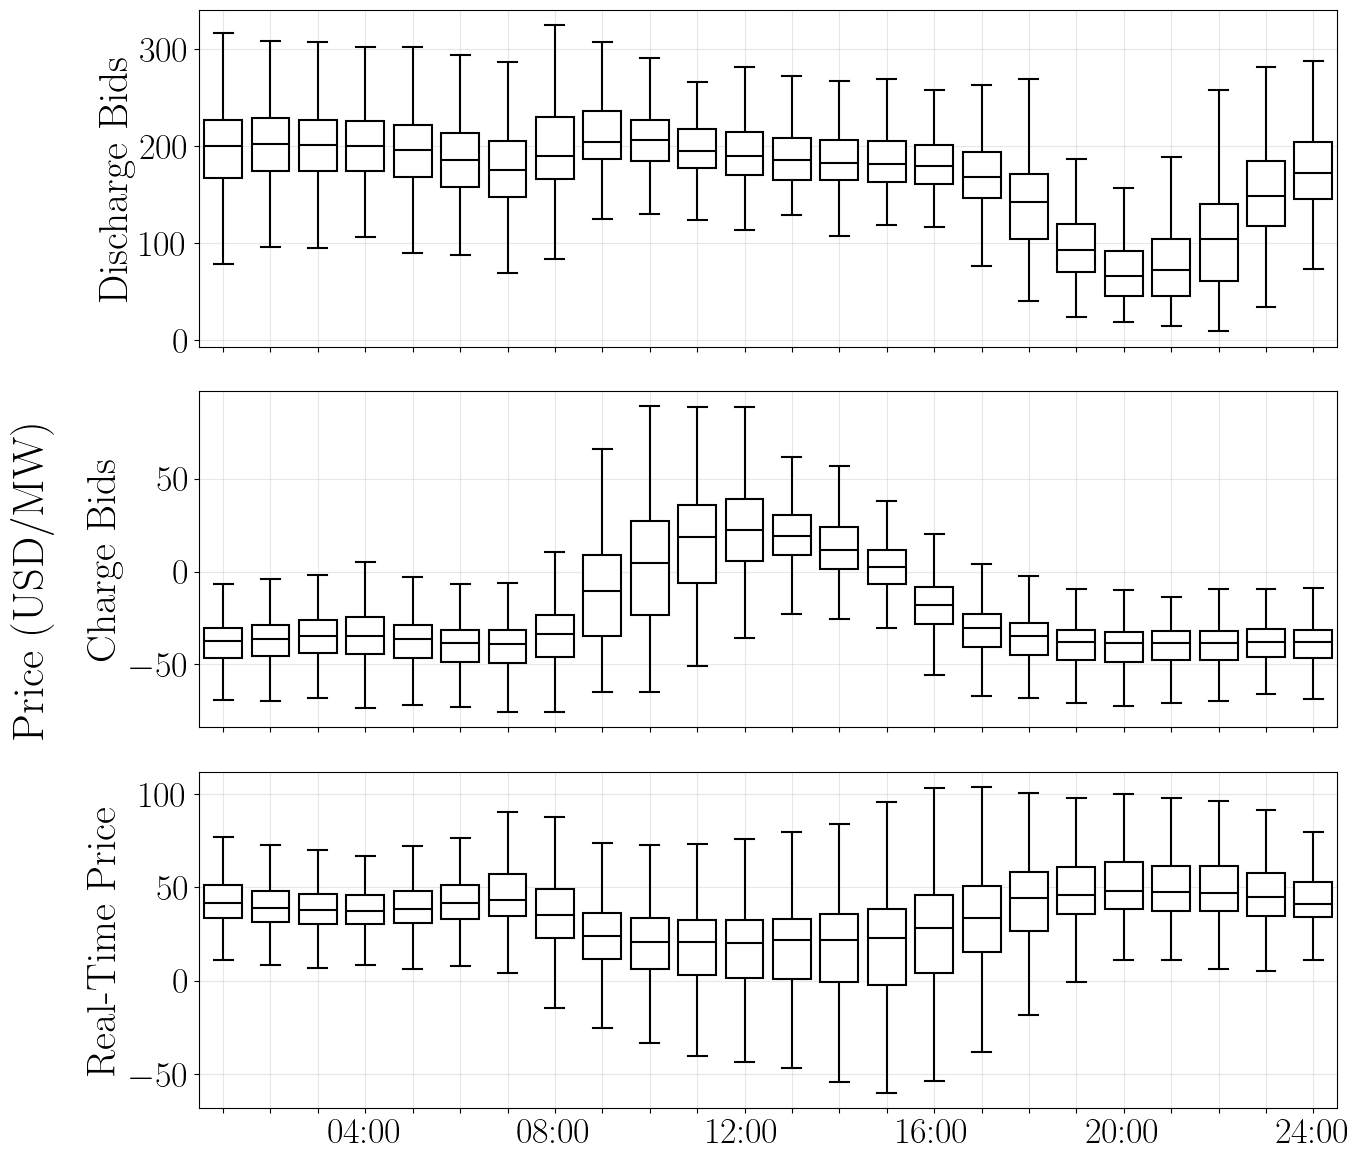

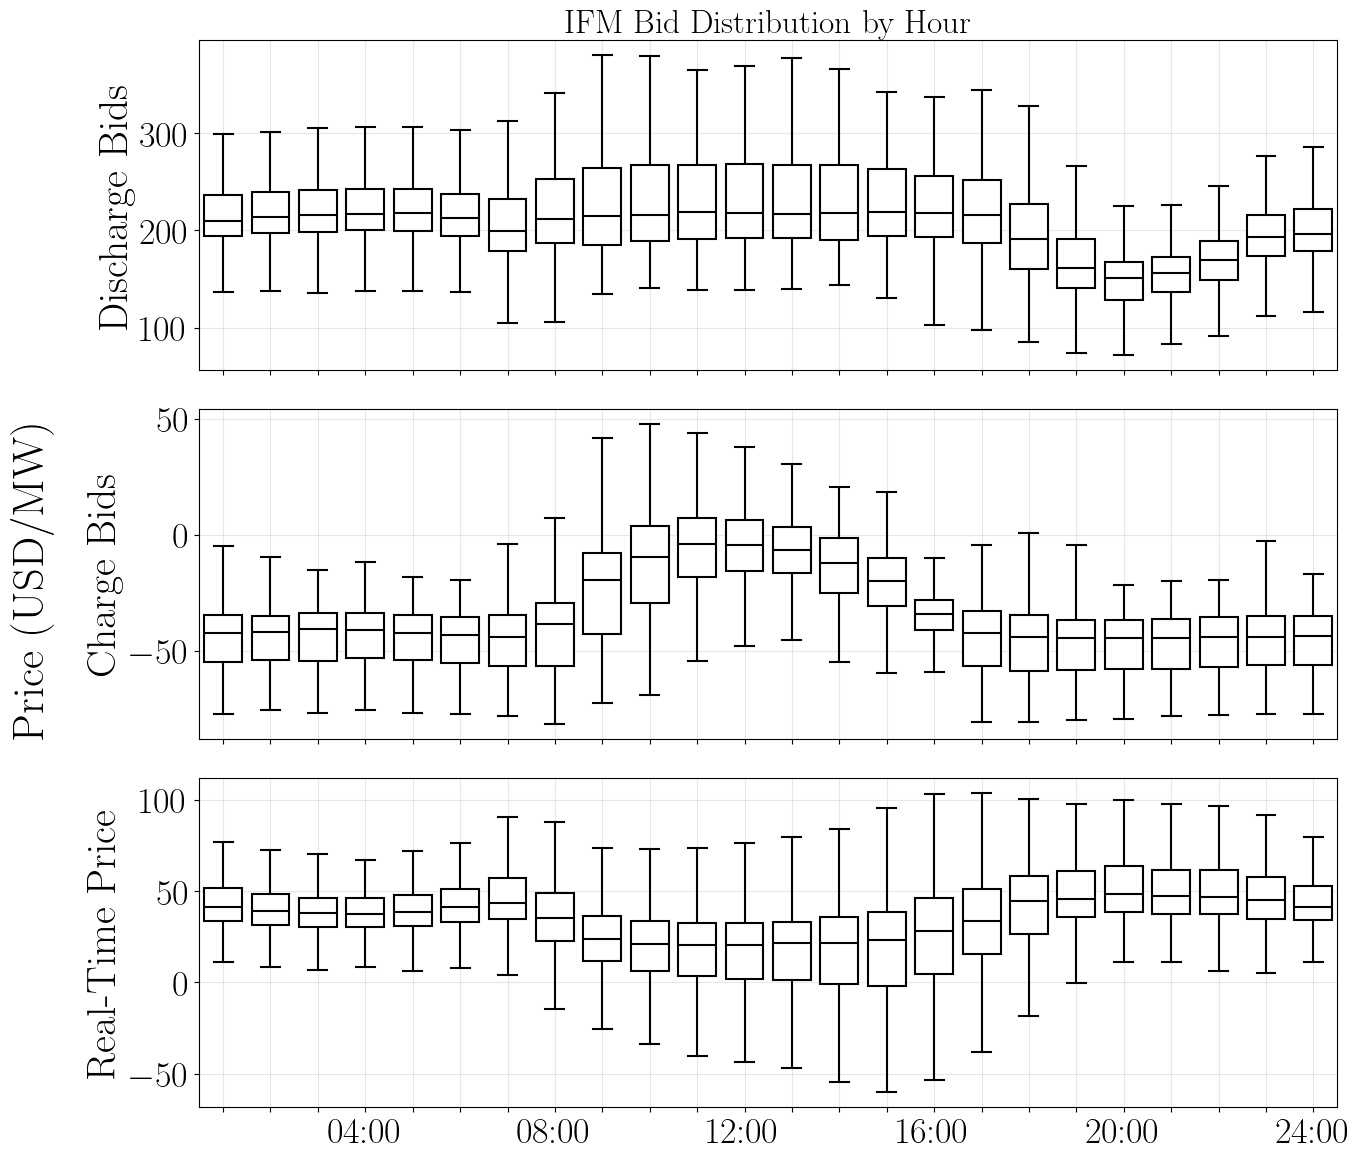

In [57]:
def plot_hourly_bid_distributions(
    data: pd.DataFrame = None,
    pos_bid_col: str = None,
    neg_bid_col: str = None,
    title: str = "",
    show_title: bool = True,
    savefig: bool = False,
):
    # Extract hour from timestamp index
    data = data.copy()
    data["hour"] = data.index.hour

    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    # Plot discharge bids on top subplot
    sns.boxplot(
        data=data,
        x="hour",
        y=pos_bid_col,
        color="white",
        ax=ax1,
        linewidth=1.5,
        boxprops={"edgecolor": "black"},
        whiskerprops={"color": "black"},
        capprops={"color": "black"},
        medianprops={"color": "black"},
        showfliers=False,
    )

    ax1.set_ylabel("Discharge Bids", fontsize=30)
    ax1.set_xlabel("")
    ax1.grid(True, alpha=0.3)
    if show_title or not title:
        ax1.set_title(title)

    # Plot charge bids on middle subplot
    sns.boxplot(
        data=data,
        x="hour",
        y=neg_bid_col,
        color="white",
        ax=ax2,
        linewidth=1.5,
        boxprops={"edgecolor": "black"},
        whiskerprops={"color": "black"},
        capprops={"color": "black"},
        medianprops={"color": "black"},
        showfliers=False,
    )

    ax2.set_ylabel("Charge Bids", fontsize=30)
    ax2.set_xlabel("")
    ax2.grid(True, alpha=0.3)

    # Plot RT price distribution on bottom subplot
    sns.boxplot(
        data=data,
        x="hour",
        y="rt_price_avg",
        color="white",
        ax=ax3,
        linewidth=1.5,
        boxprops={"edgecolor": "black"},
        whiskerprops={"color": "black"},
        capprops={"color": "black"},
        medianprops={"color": "black"},
        showfliers=False,
    )

    ax3.set_ylabel("Real-Time Price", fontsize=30)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlabel("")

    # Rotate x-axis labels for better readability
    ax3.set_xticks(range(24))
    ax3.set_xticklabels(
        [f"{h:02d}:00" if h % 4 == 0 else "" for h in range(1, 25)], rotation=0
    )
    ax3.tick_params(axis="x", labelsize=26)
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis="y", labelsize=26)
    fig.supylabel("Price (USD/MW)", fontsize=32)

    plt.tight_layout()
    if savefig:
        plt.savefig("./figures/hour_of_day_boxplot.pdf", dpi=100)
    plt.show()


# Plot distributions for RTPD and IFM bids
plot_hourly_bid_distributions(
    hourly_df,
    "bid_rtpd_pos_weighted",
    "bid_rtpd_neg_weighted",
    "RTPD Bid Distribution by Hour",
    show_title=False,
    savefig=True,
)

plot_hourly_bid_distributions(
    hourly_df,
    "bid_ifm_pos_weighted",
    "bid_ifm_neg_weighted",
    "IFM Bid Distribution by Hour",
)

### Weighted Average Bid Plots

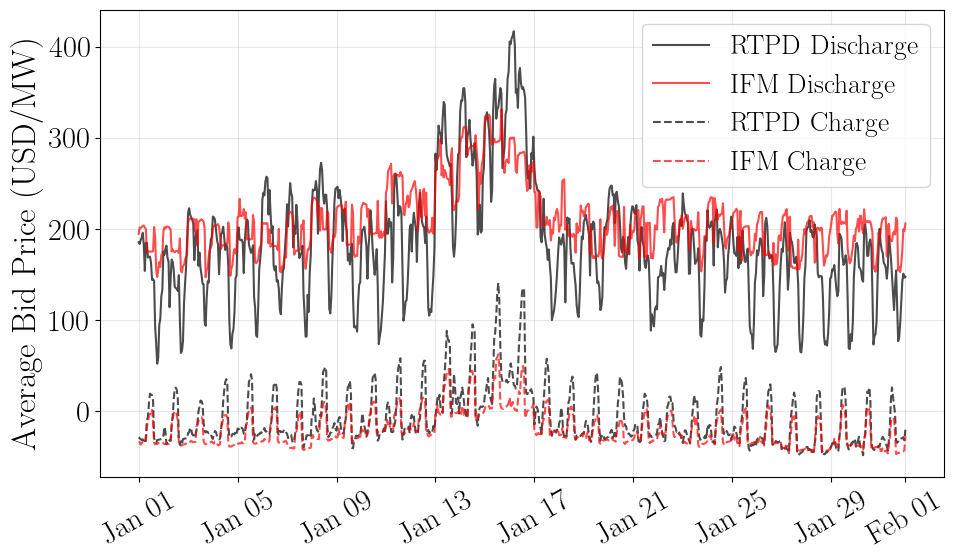

In [58]:
def plot_weighted_avg_bids(
    data: pd.DataFrame = None,
    start_date: pd.Timestamp = None,
    end_date: pd.Timestamp = None,
    granularity: str = "Hourly",
):
    """
    Plots weighted average charge and discharge bids over a specified time period.

    :param data: data frame with weighted charge/discharge bids in RTPD and IFM
    :param start_date: start date to plot
    :param end_date: end date to plot
    """
    # Create single plot
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.rcParams.update({"font.size": 20})

    # Set tick parameters
    ax.tick_params(axis="both", which="major", labelsize=18)
    ax.tick_params(axis="x", rotation=15)

    data_copy = data.copy()

    if start_date:
        data_copy = data_copy[data_copy.index >= start_date]
    if end_date:
        data_copy = data_copy[data_copy.index <= end_date]

    # Plot all bids on single plot
    ax.plot(
        data_copy.index,
        data_copy["bid_rtpd_pos_weighted"],
        label="RTPD Discharge",
        color="black",
        alpha=0.7,
    )
    ax.plot(
        data_copy.index,
        data_copy["bid_ifm_pos_weighted"],
        label="IFM Discharge",
        color="red",
        alpha=0.7,
    )
    ax.plot(
        data_copy.index,
        data_copy["bid_rtpd_neg_weighted"],
        label="RTPD Charge",
        color="black",
        alpha=0.7,
        linestyle="--",
    )
    ax.plot(
        data_copy.index,
        data_copy["bid_ifm_neg_weighted"],
        label="IFM Charge",
        color="red",
        alpha=0.7,
        linestyle="--",
    )

    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax.tick_params(axis="x", labelsize=22, rotation=30)
    ax.tick_params(axis="y", labelsize=22)

    plt.ylabel("Average Bid Price (USD/MW)", fontsize=24)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("./figures/weighted_average_bids_jan.pdf", dpi=100, bbox_inches="tight")


plot_weighted_avg_bids(
    data=hourly_df,
    start_date=pd.Timestamp("January 1, 2024"),
    end_date=pd.Timestamp("February 1, 2024"),
    granularity="Hourly",
)

In [59]:
# proportion of hours where weighted average discharge bids RTPD < IFM
discharge_mask = hourly_df.bid_rtpd_pos_weighted < hourly_df.bid_ifm_pos_weighted


print(sum([1 for d in discharge_mask if d]) / len(discharge_mask))


# proportion of hours where weighted average charge bids IFM < RTPD


charge_mask = hourly_df.bid_rtpd_neg_weighted > hourly_df.bid_ifm_neg_weighted


print(sum([1 for d in charge_mask if d]) / len(charge_mask))

0.7899572455198763
0.8771945783680524


### Plotting Optimal Hindsight vs. Historical Weighted Average Charge/Discharge Bids

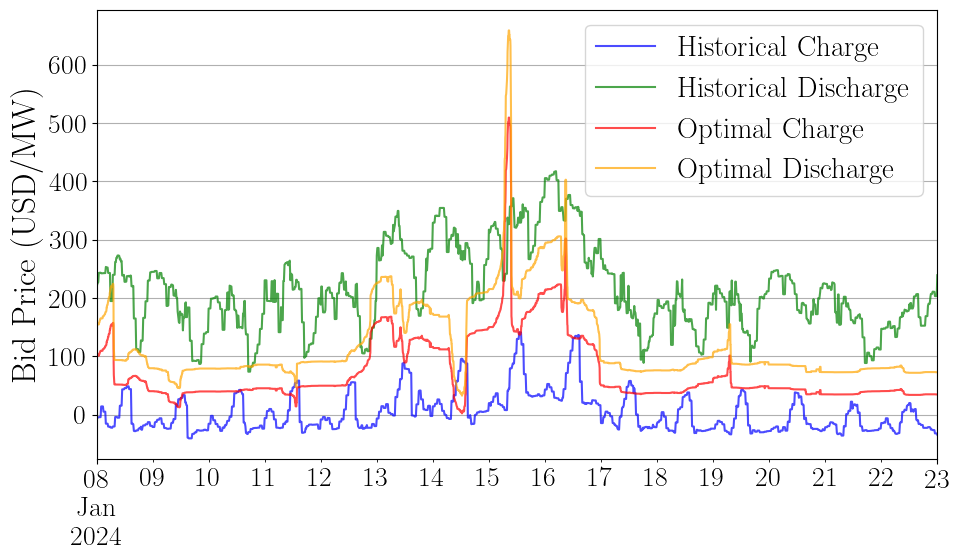

In [60]:
def plot_optimal_vs_historical(
    df: pd.DataFrame = None,
    optimal_df: pd.DataFrame = None,
    start_date: pd.Timestamp = None,
    end_date: pd.Timestamp = None,
    window: int = 1,
    savefig: bool = False,
):
    """
    Plot optimal hindsight vs historical weighted average charge/discharge bids for RTPD.

    :param df: DataFrame containing historical bid data
    :param optimal_df: DataFrame containing optimal hindsight bids
    :param start_date: Start date for plotting
    :param end_date: End date for plotting
    """

    # Filter data for date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    df_subset = df.copy().interpolate().rolling(window=window).mean()[mask]

    optimal_mask = (optimal_df.index >= start_date) & (optimal_df.index <= end_date)
    optimal_subset = optimal_df.rolling(window=window).mean()[optimal_mask]

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot RTPD data
    df_subset["bid_rtpd_neg_weighted"].plot(
        ax=ax, label="Historical Charge", color="blue", alpha=0.7
    )
    df_subset["bid_rtpd_pos_weighted"].plot(
        ax=ax, label="Historical Discharge", color="green", alpha=0.7
    )
    optimal_subset["optimal_charge"].plot(
        ax=ax, label="Optimal Charge", color="red", alpha=0.7
    )
    optimal_subset["optimal_discharge"].plot(
        ax=ax, label="Optimal Discharge", color="orange", alpha=0.7
    )
    ax.set_ylabel("Bid Price (USD/MW)", fontsize=24)
    ax.set_xlabel("")
    ax.legend(fontsize=21)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    ax.grid(True)
    plt.tight_layout()
    if savefig:
        plt.savefig("./figures/historical_optimal_bids.pdf", dpi=100)
    plt.show()


# Example usage
plot_optimal_vs_historical(
    df=full_df,
    optimal_df=optimal_bids,
    start_date=pd.Timestamp("January 8, 2024"),
    end_date=pd.Timestamp("January 23, 2024"),
    window=1,
    savefig=True,
)

### Fourier Analysis of Daily Weighted Average Bid Charge/Discharge

Optimal Charge:		7.882273725363563
Historical Charge:	29.390552919278246
Optimal Discharge:	9.73120213007847
Historical Discharge:	59.89676652383023


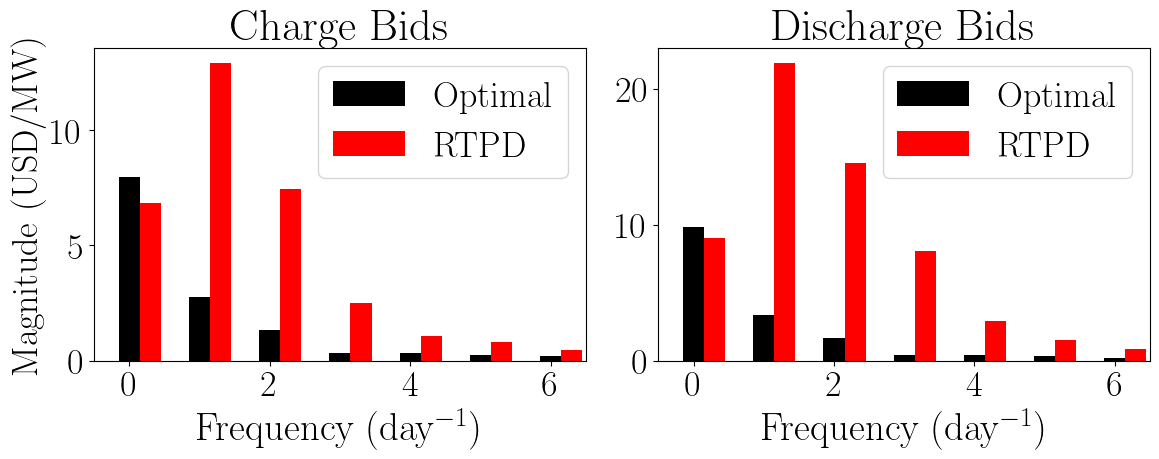

In [61]:
def fft_analysis(data, title, periods_per_day):
    # Get FFT
    fft_result = np.fft.fft(data) / len(data)
    freqs = np.fft.fftfreq(len(data))

    # Convert frequencies to 1/day
    freqs = freqs * periods_per_day

    # Get amplitudes and sort by magnitude
    amplitudes = np.abs(fft_result)
    sorted_indices = np.argsort(amplitudes)[::-1]

    # Get top 5 frequencies
    top_freqs = freqs[sorted_indices][:5]
    top_amps = amplitudes[sorted_indices][:5]

    # Convert frequencies to periods (in days)
    periods = 1 / np.abs(top_freqs[top_freqs != 0])

    return fft_result, freqs, amplitudes


# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# RTPD Analysis
fft_discharge_rtpd, freqs_rtpd, amp_discharge_rtpd = fft_analysis(
    full_df["bid_rtpd_pos_weighted"].dropna().values, "RTPD Discharge Bids", 24 * 4
)
fft_charge_rtpd, _, amp_charge_rtpd = fft_analysis(
    full_df["bid_rtpd_neg_weighted"].dropna().values, "RTPD Charge Bids", 24 * 4
)

# Perform FFT analysis on optimal bids
fft_charge_opt, freqs_opt, amp_charge_opt = fft_analysis(
    optimal_bids["optimal_charge"].values, "Optimal Charge Bids", 24 * 12
)
fft_discharge_opt, _, amp_discharge_opt = fft_analysis(
    optimal_bids["optimal_discharge"].values, "Optimal Discharge Bids", 24 * 12
)


# Function to bin frequencies and get max amplitude per bin
def bin_frequencies(freqs, amps, bin_width=1.0):
    bins = {}
    for f, a in zip(freqs[1 : len(freqs) // 2], amps[1 : len(freqs) // 2]):
        bin_center = round(f)
        if bin_center >= 0:  # Only consider non-negative frequencies
            if bin_center not in bins:
                bins[bin_center] = a
            else:
                bins[bin_center] = max(bins[bin_center], a)
    print(sum(list(bins.values())[1:]))
    return np.array(list(bins.keys())), np.array(list(bins.values()))


# Bin the frequencies and get max amplitudes
print("Optimal Charge:\t\t", end="")
freqs_charge_opt_binned, amp_charge_opt_binned = bin_frequencies(
    freqs_opt, amp_charge_opt
)
print("Historical Charge:\t", end="")
freqs_charge_rtpd_binned, amp_charge_rtpd_binned = bin_frequencies(
    freqs_rtpd, amp_charge_rtpd
)
print("Optimal Discharge:\t", end="")
freqs_discharge_opt_binned, amp_discharge_opt_binned = bin_frequencies(
    freqs_opt, amp_discharge_opt
)
print("Historical Discharge:\t", end="")
freqs_discharge_rtpd_binned, amp_discharge_rtpd_binned = bin_frequencies(
    freqs_rtpd, amp_discharge_rtpd
)

# Plot FFT results with binned frequencies
# Charge bids
ax1.bar(
    freqs_charge_opt_binned,
    amp_charge_opt_binned,
    color="black",
    label="Optimal",
    width=0.3,
)
ax1.bar(
    freqs_charge_rtpd_binned + 0.3,  # Offset for visibility
    amp_charge_rtpd_binned,
    color="red",
    label="RTPD",
    width=0.3,
)

# Discharge bids
ax2.bar(
    freqs_discharge_opt_binned,
    amp_discharge_opt_binned,
    color="black",
    label="Optimal",
    width=0.3,
)
ax2.bar(
    freqs_discharge_rtpd_binned + 0.3,  # Offset for visibility
    amp_discharge_rtpd_binned,
    color="red",
    label="RTPD",
    width=0.3,
)

# Set labels and titles
ax1.set_title("Charge Bids", fontsize=32)
ax1.set_xlabel(r"Frequency (day$^{-1}$)", fontsize=28)
ax1.set_ylabel("Magnitude (USD/MW)", fontsize=26)
ax1.set_xlim(-0.5, 6.5)
ax1.tick_params(axis="x", labelsize=26)
ax1.tick_params(axis="y", labelsize=26)

ax2.set_title("Discharge Bids", fontsize=32)
ax2.set_xlabel("Frequency (day$^{-1}$)", fontsize=28)
ax2.set_xlim(-0.5, 6.5)
ax2.tick_params(axis="x", labelsize=26)
ax2.tick_params(axis="y", labelsize=26)

# Add legends
ax1.legend(loc="upper right", fontsize=26)
ax2.legend(loc="upper right", fontsize=26)

plt.tight_layout()
plt.savefig("./figures/historical_optimal_fft.pdf", dpi=100)
plt.show()

### Price Spike Identification

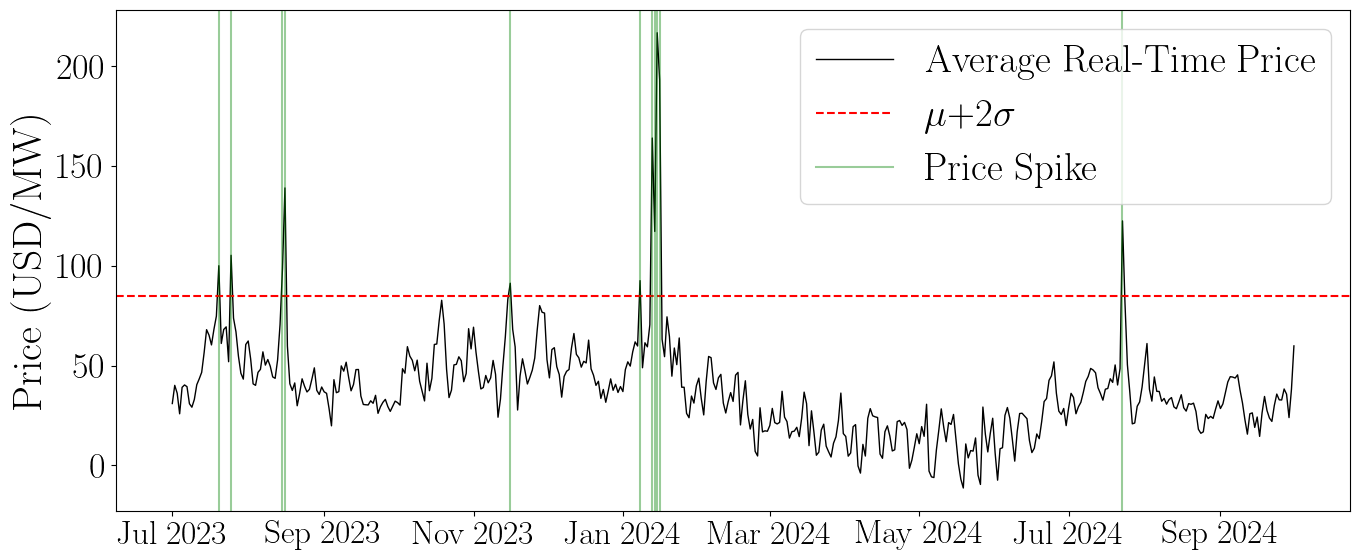

DatetimeIndex(['2023-07-20', '2023-07-25', '2023-08-15', '2023-08-16',
               '2023-11-16', '2024-01-08', '2024-01-13', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-07-23'],
              dtype='datetime64[ns]', freq=None)


In [62]:
def identify_spikes(
    data: pd.DataFrame = None,
    start_date: pd.Timestamp = None,
    end_date: pd.Timestamp = None,
    column: str = "",
    std_threshold: int = 2,
    graph=True,
    description: str = "",
    savefig: bool = False,
):
    """
    Identifies and returns all timestamps in data where column value exceeds std_threshold above the mean of column value.
    Graphing feature can be activated/deactivated and further tuned using start_date and end_date.
    """
    # copy data
    data_copy = data.copy()
    description = column if description == "" else description

    # determine distribution statistics
    mean = data_copy[column].mean()
    std = data_copy[column].std()
    threshold = mean + std_threshold * std
    abnormal_timestamps = data_copy[data[column] > threshold].index

    if graph:
        plt.figure(figsize=(14, 6))
        if start_date:
            data_copy = data_copy[data.index >= start_date]
        if end_date:
            data_copy = data_copy[data.index <= end_date]
        plt.plot(
            data_copy.index,
            data_copy[column],
            color="black",
            label=description,
            linewidth=1,
        )
        plt.axhline(
            y=threshold,
            color="r",
            linestyle="--",
            label=r"$\mu +$" + str(std_threshold) + r"$\sigma$",
        )

        filtered_abnormal_timestamps = abnormal_timestamps.copy()
        if start_date:
            filtered_abnormal_timestamps = [
                date for date in filtered_abnormal_timestamps if date >= start_date
            ]
        if end_date:
            filtered_abnormal_timestamps = [
                date for date in filtered_abnormal_timestamps if date <= end_date
            ]

        for idx, timestamp in enumerate(filtered_abnormal_timestamps):
            plt.axvline(
                x=timestamp,
                color="green",
                alpha=0.4,
                label=("Price Spike" if idx == 0 else None),
            )
        plt.legend(fontsize=28)
        plt.tick_params(axis="x", labelsize="24")
        plt.tick_params(axis="y", labelsize="26")
        # plt.title(f"Abnormality Detection in {description}")
        # plt.xlabel("Date")
        plt.ylabel("Price (USD/MW)", fontsize=30)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
        plt.tight_layout()
        if savefig:
            plt.savefig("./figures/price_spike_identified.pdf", dpi=100)
        plt.show()

    del data_copy

    return abnormal_timestamps


RTP_spike_days_avg = identify_spikes(
    data=daily_df,
    column="rt_price_avg",
    description="Average Real-Time Price",
    savefig=True,
)
print(RTP_spike_days_avg)

In [63]:
# calculate all price spike days for analysis later
RTP_spike_days_max = identify_spikes(
    data=daily_df,
    column="rt_price_max",
    description="Maximum Real-Time Price",
    graph=False,
)


RTP_spike_days_min = identify_spikes(
    data=daily_df,
    column="rt_price_min",
    description="Minimum Real-Time Price",
    graph=False,
)


DAP_spike_days_avg = identify_spikes(
    data=daily_df,
    column="da_price_avg",
    description="Average Day-Ahead Price",
    graph=False,
)


DAP_spike_days_max = identify_spikes(
    data=daily_df,
    column="da_price_max",
    description="Maximum Day-Ahead Price",
    graph=False,
)


DAP_spike_days_min = identify_spikes(
    data=daily_df,
    column="da_price_min",
    description="Minimum Day-Ahead Price",
    graph=False,
)


RTPD_discharge_days = identify_spikes(
    data=daily_df,
    column="bid_rtpd_pos_weighted",
    description="RTPD Discharge",
    graph=False,
)


RTPD_charge_days = identify_spikes(
    data=daily_df,
    column="bid_rtpd_neg_weighted",
    description="RTPD Charge",
    graph=False,
)


RTPD_spread_days = identify_spikes(
    data=daily_df,
    column="bid_rtpd_weighted_spread",
    description="RTPD Spread",
    graph=False,
)


IFM_discharge_days = identify_spikes(
    data=daily_df,
    column="bid_ifm_pos_weighted",
    description="IFM Discharge",
    graph=False,
)


IFM_charge_days = identify_spikes(
    data=daily_df, column="bid_ifm_neg_weighted", description="IFM Charge", graph=False
)


IFM_spread_days = identify_spikes(
    data=daily_df,
    column="bid_ifm_weighted_spread",
    description="IFM Spread",
    graph=False,
)

### Hourly Weighted Bids on Price Spike vs. Non-Price Spike Days

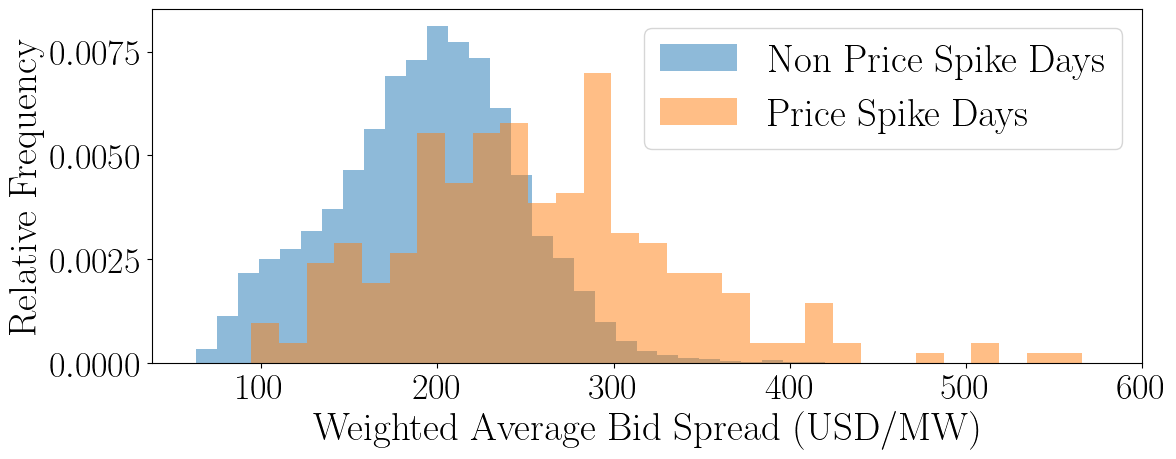

Real-Time Average rtpd
KS Statistic: 0.3856293706293706
P-value: 4.912124507459774e-35
n price spike: 264
n non price spike: 10725


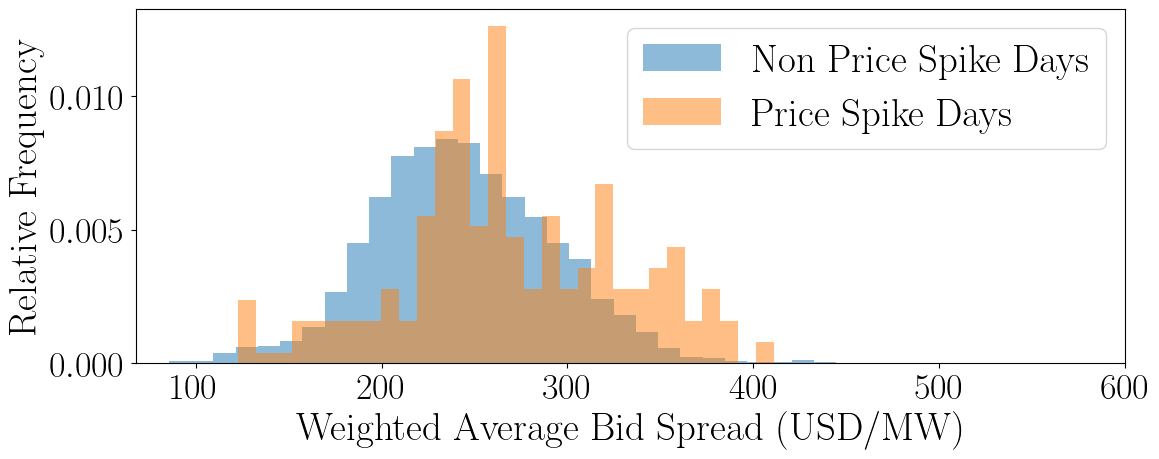

Real-Time Average ifm
KS Statistic: 0.20762999118703815
P-value: 3.11233652528492e-10
n price spike: 264
n non price spike: 10728


In [64]:
def plot_price_spike_distributions(
    data: pd.DataFrame = None,
    spike_days: list = None,
    market: str = None,
    spike_days_description: str = None,
    savefig: bool = False,
):
    # Separate the data into price spike days and non-price spike days
    price_spike_hourly_index = data.index.floor("D").isin(spike_days)

    # Plot the histograms
    plt.figure(figsize=(12, 5))

    # Get max value to determine x-axis limit
    max_val = max(
        data[~price_spike_hourly_index][f"bid_{market.lower()}_weighted_spread"].max(),
        data[price_spike_hourly_index][f"bid_{market.lower()}_weighted_spread"].max(),
    )
    # Round up to nearest even multiple of tick marks (using 10 as tick interval)
    max_tick = math.ceil(max_val / 10) * 10
    if max_tick % 20 != 0:
        max_tick += 10

    # Histogram for non-price spike days
    plt.hist(
        data[~price_spike_hourly_index][f"bid_{market.lower()}_weighted_spread"],
        bins=30,
        alpha=0.5,
        label="Non Price Spike Days",
        density=True,
    )

    # Histogram for price spike days
    plt.hist(
        data[price_spike_hourly_index][f"bid_{market.lower()}_weighted_spread"],
        bins=30,
        alpha=0.5,
        label="Price Spike Days",
        density=True,
    )

    plt.xlabel("Weighted Average Bid Spread (USD/MW)", fontsize=28)
    plt.ylabel("Relative Frequency", fontsize=28)
    plt.legend(fontsize=28)
    plt.tick_params(axis="x", labelsize="26")
    plt.tick_params(axis="y", labelsize="26")
    plt.xlim(right=600)

    plt.tight_layout()
    if savefig:
        plt.savefig("./figures/spike_nonspike_dist.pdf", dpi=100)

    # Show the plot
    plt.show()

    # Extract the data for KS test
    price_spike_data = (
        data[price_spike_hourly_index][f"bid_{market.lower()}_weighted_spread"]
        .dropna()
        .values
    )
    non_price_spike_data = (
        data[~price_spike_hourly_index][f"bid_{market.lower()}_weighted_spread"]
        .dropna()
        .values
    )

    # Perform the KS test
    ks_statistic, p_value = ks_2samp(price_spike_data, non_price_spike_data)

    # Print the results
    print(spike_days_description, market)
    print(f"KS Statistic: {ks_statistic}")
    print(f"P-value: {p_value}")
    print("n price spike:", len(price_spike_data))
    print("n non price spike:", len(non_price_spike_data))


plot_price_spike_distributions(
    data=hourly_df,
    spike_days=RTP_spike_days_avg,
    market="rtpd",
    spike_days_description="Real-Time Average",
    savefig=True,
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=RTP_spike_days_avg,
    market="ifm",
    spike_days_description="Real-Time Average",
)

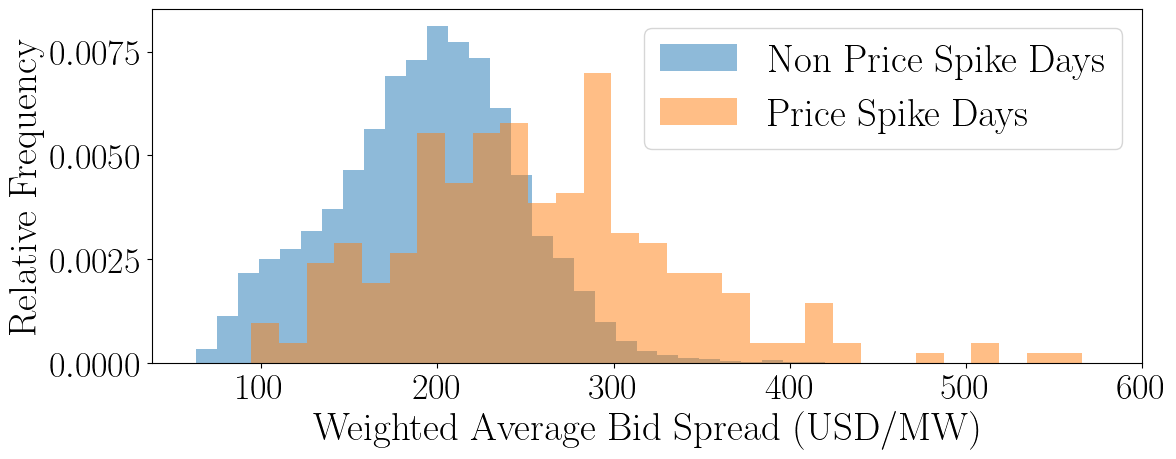

Real-Time Average rtpd
KS Statistic: 0.3856293706293706
P-value: 4.912124507459774e-35
n price spike: 264
n non price spike: 10725


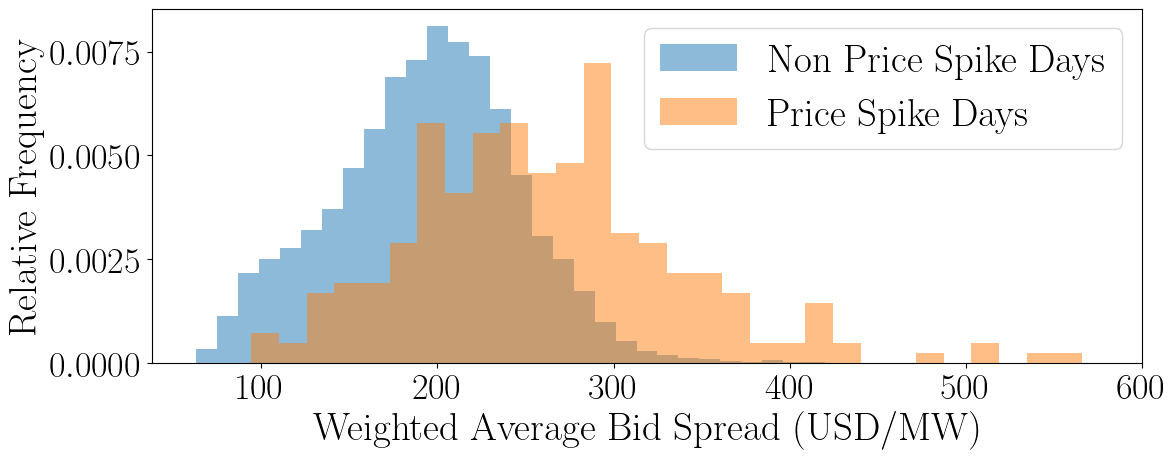

Real-Time Minimum rtpd
KS Statistic: 0.41279720279720283
P-value: 2.6894217974766363e-40
n price spike: 264
n non price spike: 10725


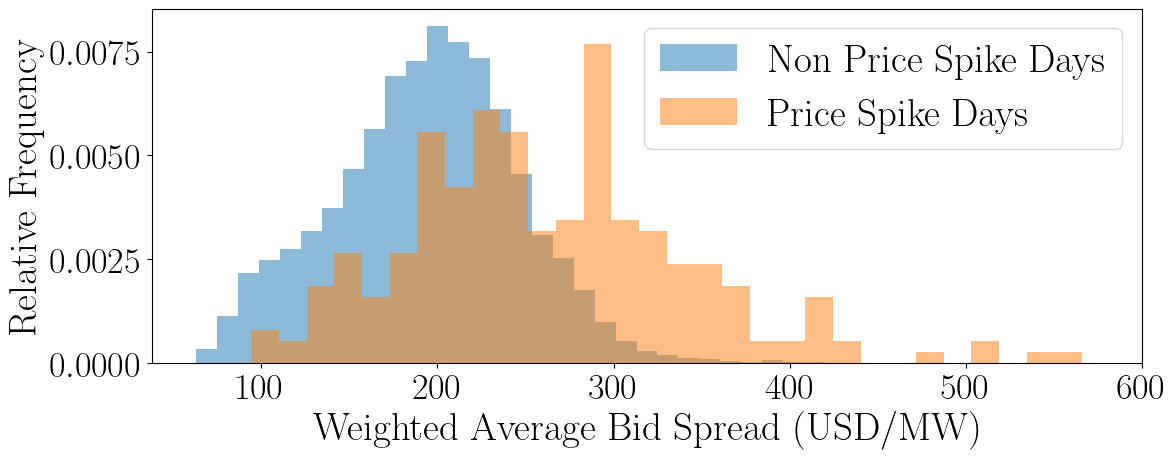

Real-Time Maximum rtpd
KS Statistic: 0.39803702670015817
P-value: 4.241108530993637e-34
n price spike: 240
n non price spike: 10749


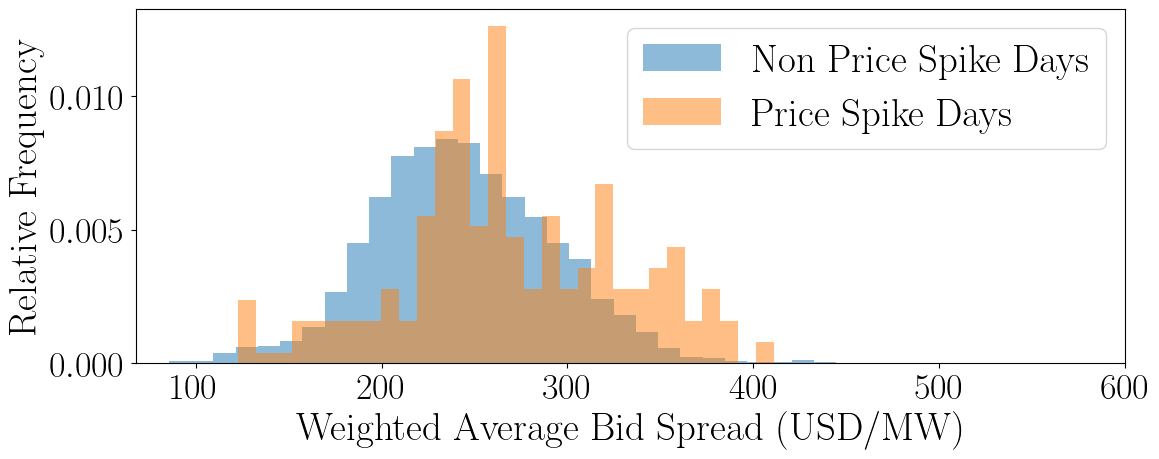

Real-Time Average ifm
KS Statistic: 0.20762999118703815
P-value: 3.11233652528492e-10
n price spike: 264
n non price spike: 10728


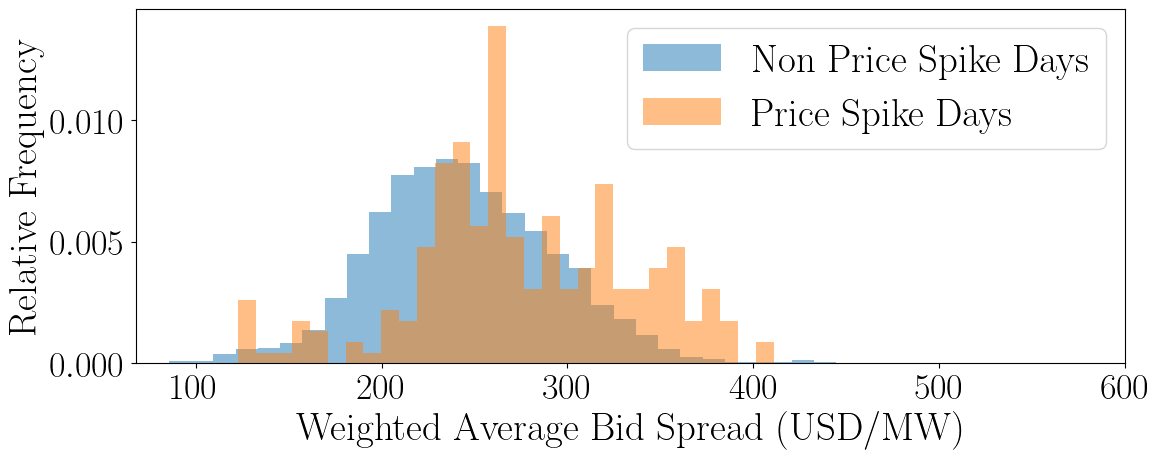

Real-Time Maximum ifm
KS Statistic: 0.25755208333333335
P-value: 3.1006646112879656e-14
n price spike: 240
n non price spike: 10752


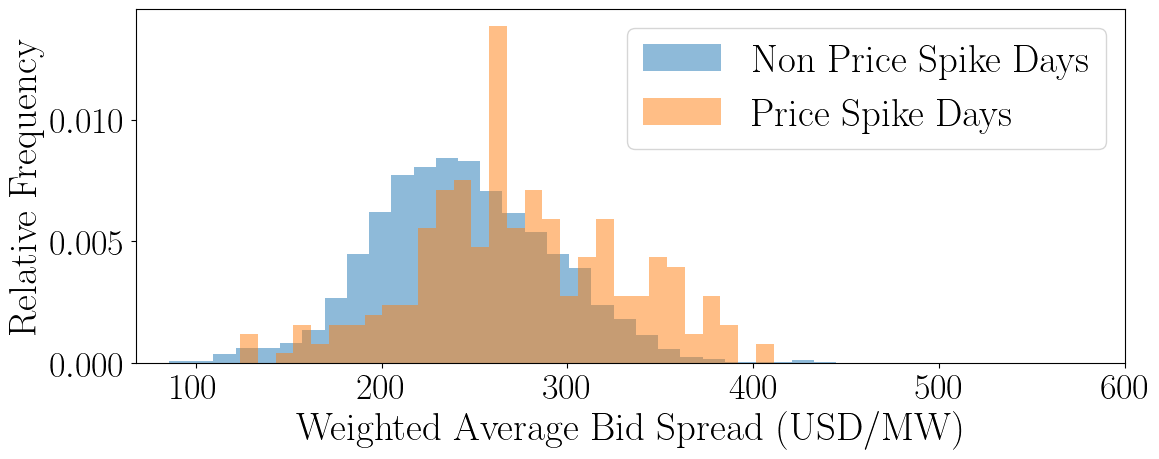

Real-Time Minimum ifm
KS Statistic: 0.26627855738594
P-value: 1.2213130055074525e-16
n price spike: 264
n non price spike: 10728


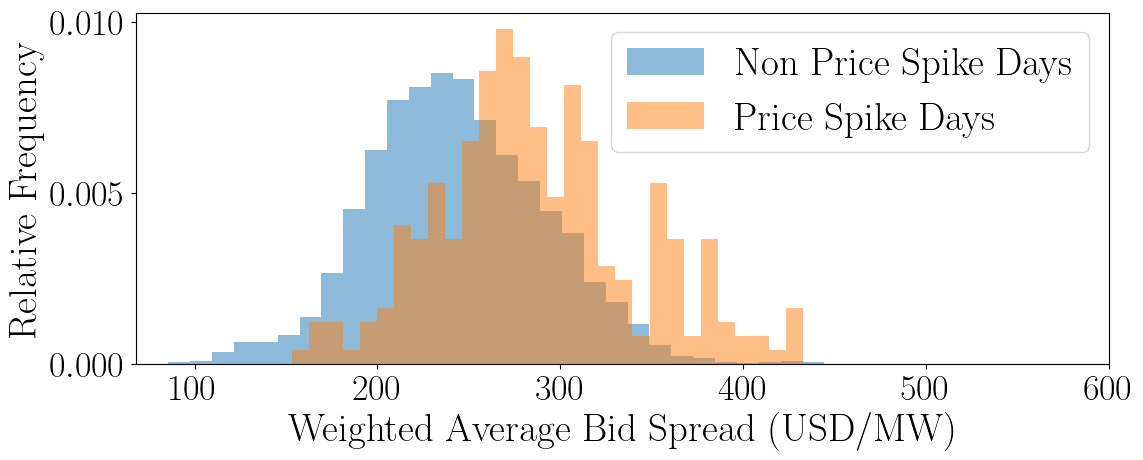

Day-Ahead Average ifm
KS Statistic: 0.3602298149278015
P-value: 1.726399000266834e-30
n price spike: 264
n non price spike: 10728


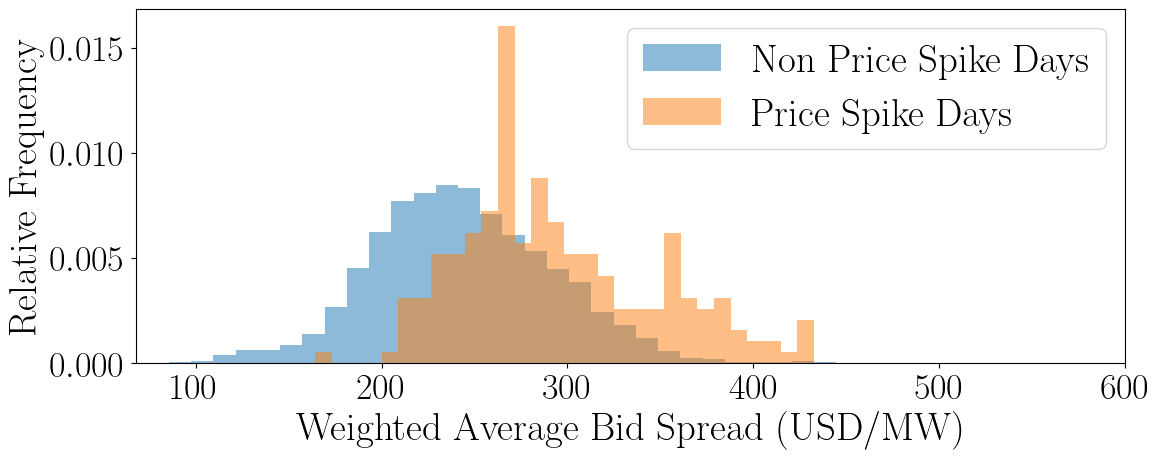

Day-Ahead Minimum ifm
KS Statistic: 0.40762393796914953
P-value: 2.3586325237227303e-32
n price spike: 216
n non price spike: 10776


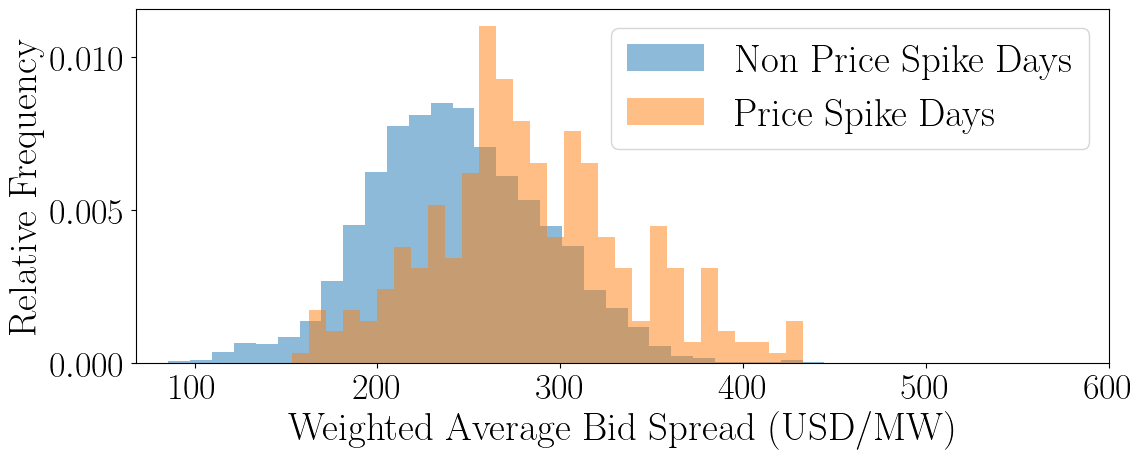

Day-Ahead Maximum ifm
KS Statistic: 0.345880149812734
P-value: 6.937620295775304e-33
n price spike: 312
n non price spike: 10680


In [65]:
plot_price_spike_distributions(
    data=hourly_df,
    spike_days=RTP_spike_days_avg,
    market="rtpd",
    spike_days_description="Real-Time Average",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=RTP_spike_days_min,
    market="rtpd",
    spike_days_description="Real-Time Minimum",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=RTP_spike_days_max,
    market="rtpd",
    spike_days_description="Real-Time Maximum",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=RTP_spike_days_avg,
    market="ifm",
    spike_days_description="Real-Time Average",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=RTP_spike_days_max,
    market="ifm",
    spike_days_description="Real-Time Maximum",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=RTP_spike_days_min,
    market="ifm",
    spike_days_description="Real-Time Minimum",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=DAP_spike_days_avg,
    market="ifm",
    spike_days_description="Day-Ahead Average",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=DAP_spike_days_min,
    market="ifm",
    spike_days_description="Day-Ahead Minimum",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=DAP_spike_days_max,
    market="ifm",
    spike_days_description="Day-Ahead Maximum",
)

### Example: January 16, 2024

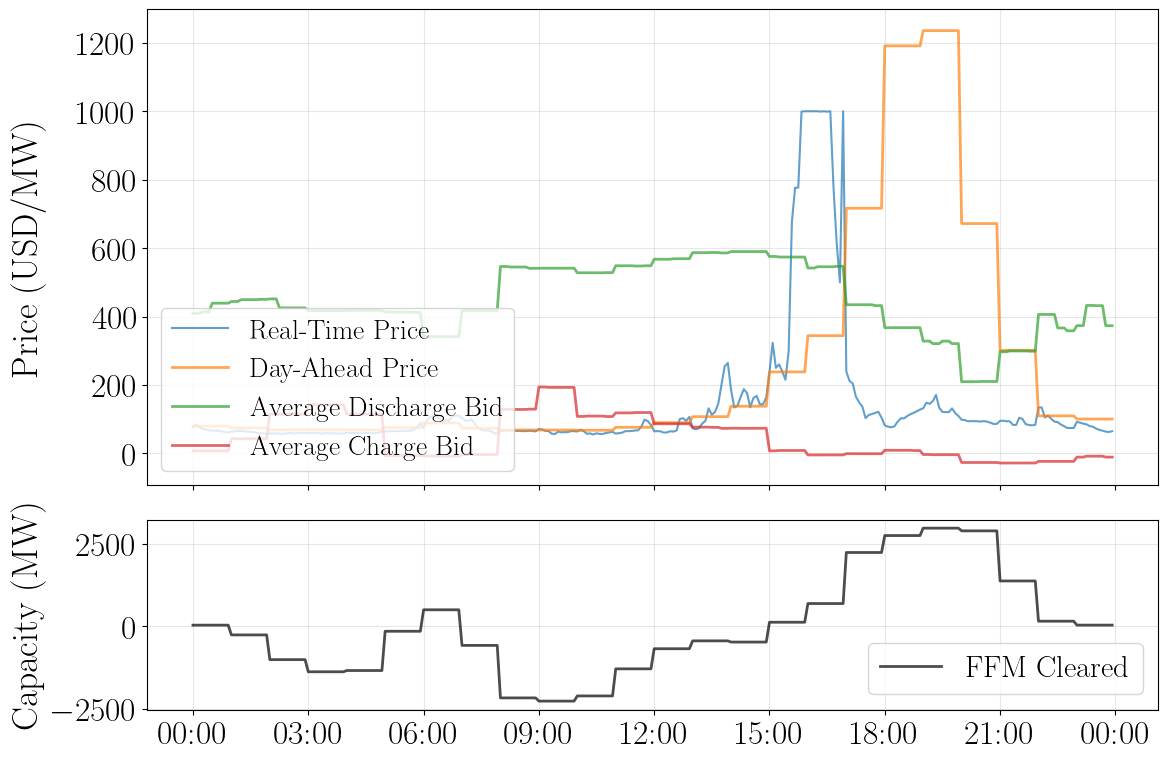

In [74]:
def plot_prices_for_date(date_str, savefig: bool = False):
    """
    Plot RT and DA prices for a specific date

    Args:
        date_str (str): Date in format 'YYYY-MM-DD'
    """
    # Convert string to datetime
    date = pd.to_datetime(date_str)

    # Filter data for the specific date
    rt_day = full_df[full_df.index.date == date.date()]
    da_day = full_df[full_df.index.date == date.date()].ffill()

    # Create figure with two subplots, making the top subplot twice as tall as the bottom subplot
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(12, 8), gridspec_kw={"height_ratios": [2.5, 1]}, sharex=True
    )

    # Plot RT prices (5-min)
    ax1.plot(
        rt_day.index,
        rt_day.rt_price_avg,
        label="Real-Time Price",
        alpha=0.7,
    )

    # Plot DA prices (hourly)
    ax1.plot(
        da_day.index,
        da_day.da_price_avg,
        label="Day-Ahead Price",
        linewidth=2,
        alpha=0.7,
    )

    ax1.plot(
        da_day.index,
        da_day.bid_rtpd_pos_weighted,
        label="Average Discharge Bid",
        linewidth=2,
        alpha=0.7,
    )

    ax1.plot(
        da_day.index,
        da_day.bid_rtpd_neg_weighted,
        label="Average Charge Bid",
        linewidth=2,
        alpha=0.7,
    )

    ax1.set_ylabel("Price (USD/MW)", fontsize=26)
    ax1.tick_params(axis="x", labelsize=24)
    ax1.tick_params(axis="y", labelsize=24)

    # Format x-axis ticks to show hours
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    # Add legends
    ax1.legend(loc="lower left", fontsize=20)

    # Plot FFM Energy Cleared
    ax2.plot(
        da_day.index,
        da_day.tot_energy_ifm,
        label="FFM Cleared",
        linewidth=2,
        alpha=0.7,
        color="black",
    )

    ax2.set_ylabel("Capacity (MW)", fontsize=26)
    ax2.yaxis.set_label_coords(-0.1, 0.5)  # Align y labels vertically
    ax1.yaxis.set_label_coords(-0.1, 0.5)  # Align y labels vertically
    ax2.tick_params(axis="x", labelsize=24)
    ax2.tick_params(axis="y", labelsize=24)
    ax2.legend(loc="lower right", fontsize=22)

    # Format x-axis ticks to show hours
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    ax1.grid(True, alpha=0.3)
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    if savefig:
        plt.savefig("./figures/price_spike_example_day.pdf", dpi=100)
    plt.show()


# Example usage
plot_prices_for_date("2023-08-16", True)

## Supplementary Material

These figures are not used in the paper but we include them here for posterity

### Price vs. Bid Spread

In [67]:
def plot_price_bid_spread(
    data: pd.DataFrame = None,
    spike_days: list = None,
    market: str = None,
    price_col: str = None,
    spike_days_description: str = None,
):

    # Separate the data into price spike days and non-price spike days
    price_spike_hourly_index = data.index.floor("D").isin(spike_days)

    # Plot the histograms
    plt.figure(figsize=(10, 6))

    # Histogram for non-price spike days
    plt.scatter(
        data[~price_spike_hourly_index][price_col],
        data[~price_spike_hourly_index][f"bid_{market.lower()}_weighted_spread"],
        alpha=0.5,
        label="Non Price Spike Days",
        s=4,
    )

    # Histogram for price spike days
    plt.scatter(
        data[price_spike_hourly_index][price_col],
        data[price_spike_hourly_index][f"bid_{market.lower()}_weighted_spread"],
        alpha=0.5,
        label="Price Spike Days",
        s=4,
    )

    # Add title and labels
    plt.title(f"{spike_days_description} Price vs. Average {market.upper()} Bid Spread")
    plt.xlabel(f"{spike_days_description} Price (USD/MW)")
    plt.ylabel(f"Weighted Average {market.upper()} Bid Spread (USD/MW)")
    plt.legend()

    # Show the plot
    plt.show()

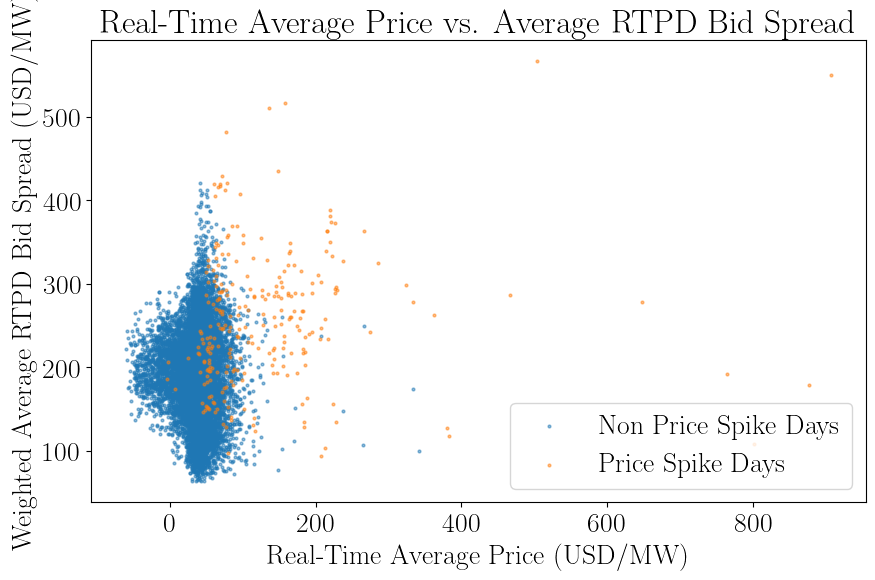

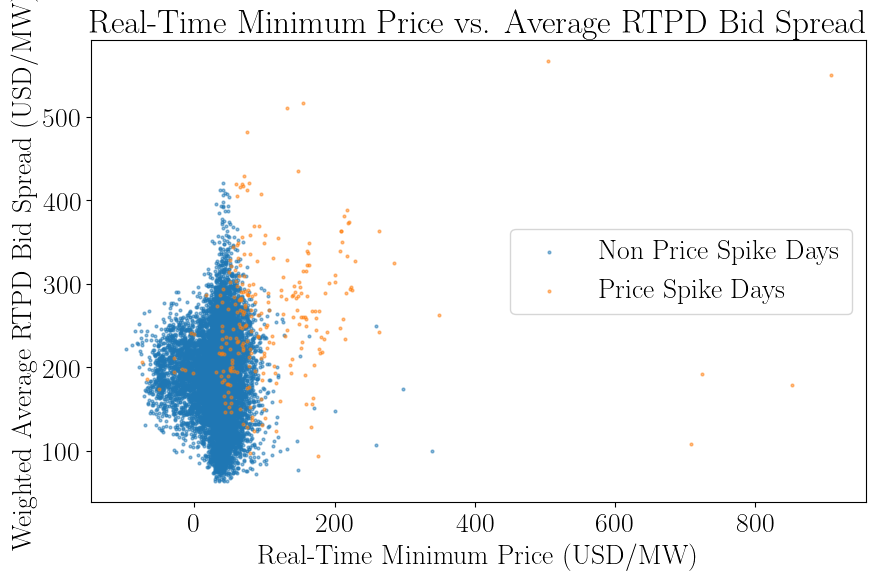

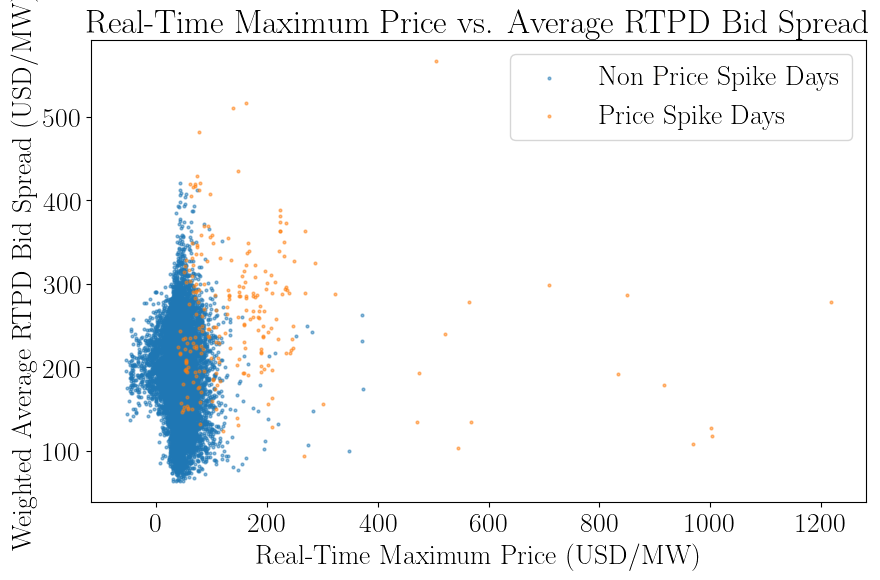

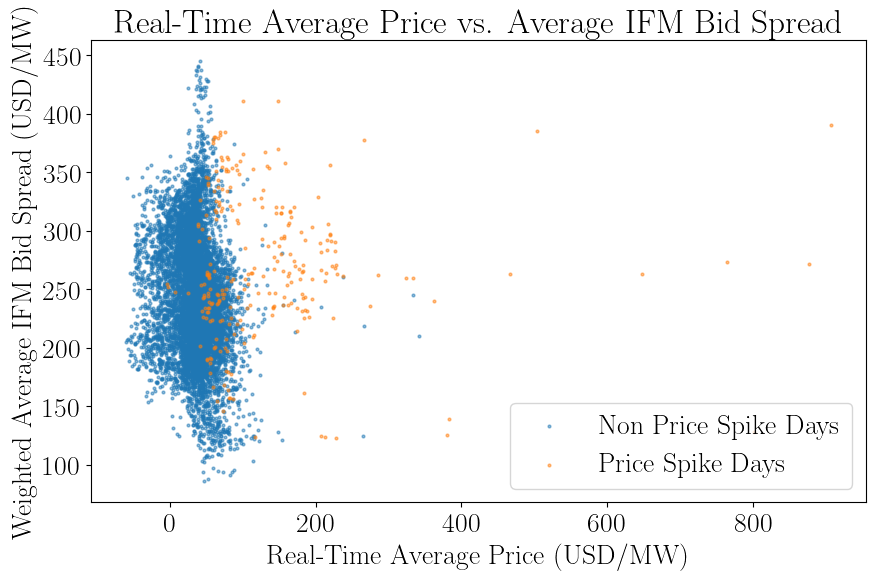

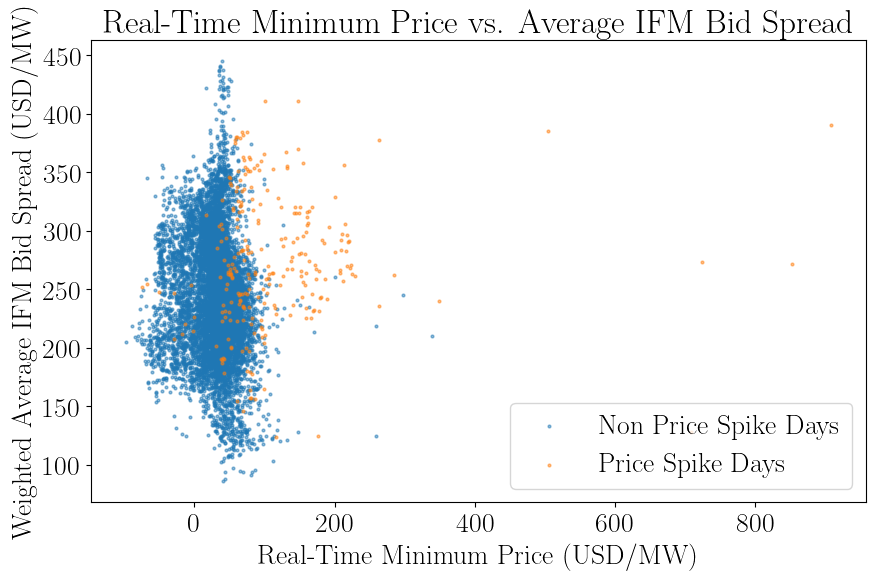

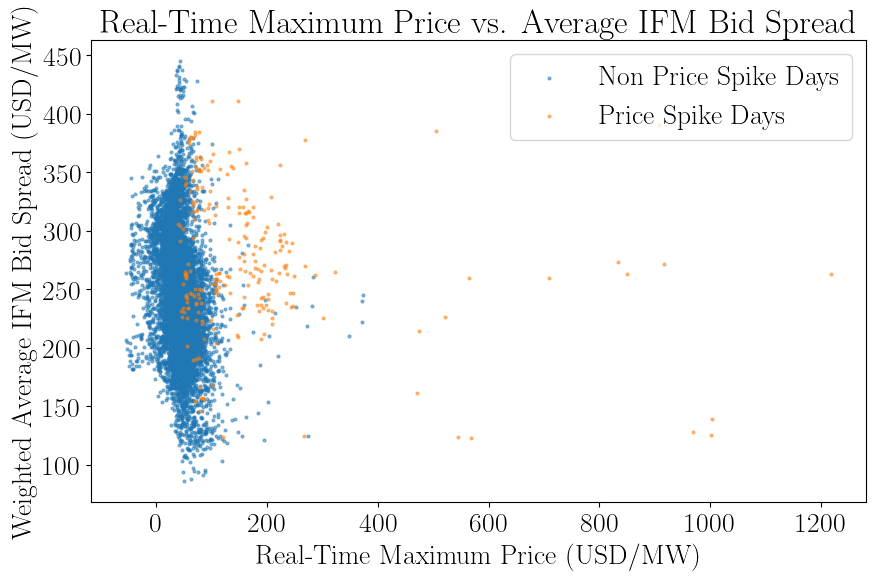

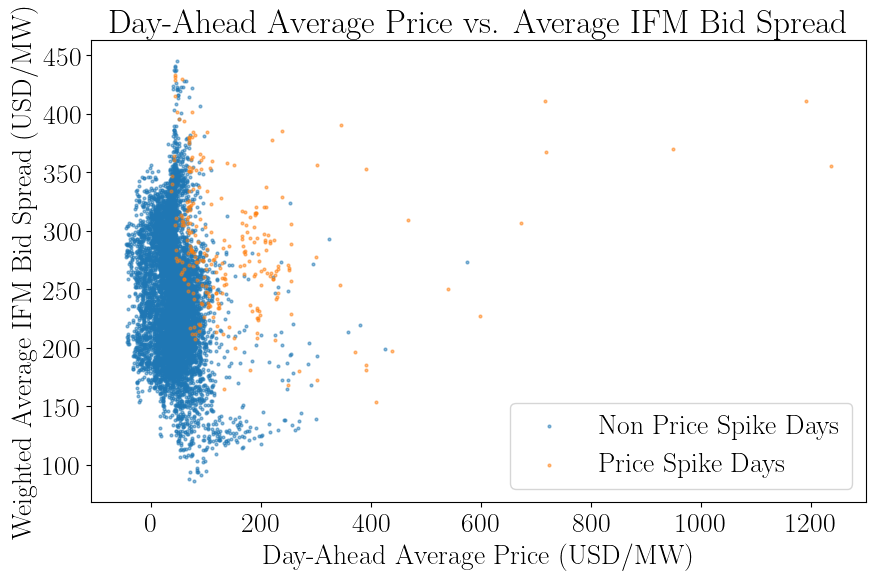

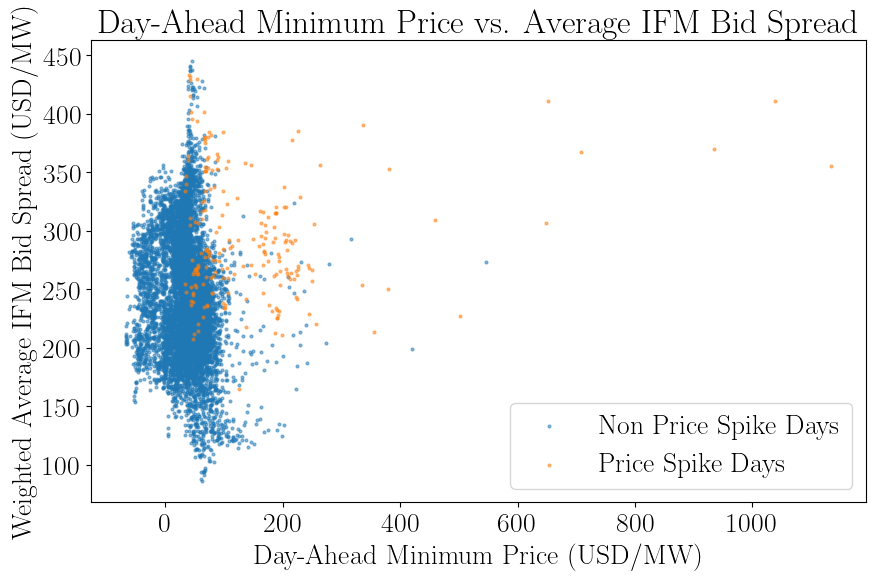

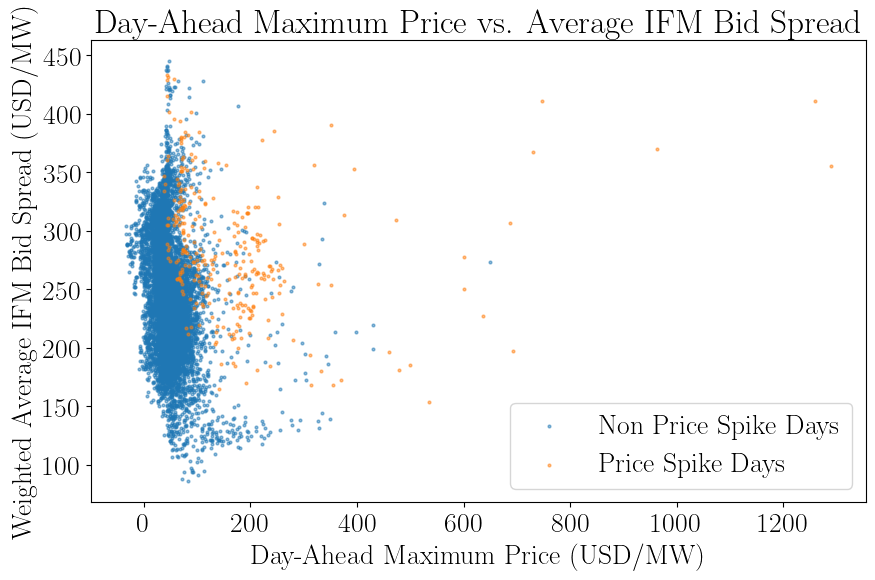

In [68]:
plot_price_bid_spread(
    data=hourly_df,
    spike_days=RTP_spike_days_avg,
    market="rtpd",
    price_col="rt_price_avg",
    spike_days_description="Real-Time Average",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=RTP_spike_days_min,
    market="rtpd",
    price_col="rt_price_min",
    spike_days_description="Real-Time Minimum",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=RTP_spike_days_max,
    market="rtpd",
    price_col="rt_price_max",
    spike_days_description="Real-Time Maximum",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=RTP_spike_days_avg,
    market="ifm",
    price_col="rt_price_avg",
    spike_days_description="Real-Time Average",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=RTP_spike_days_min,
    market="ifm",
    price_col="rt_price_min",
    spike_days_description="Real-Time Minimum",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=RTP_spike_days_max,
    market="ifm",
    price_col="rt_price_max",
    spike_days_description="Real-Time Maximum",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=DAP_spike_days_avg,
    market="ifm",
    price_col="da_price_avg",
    spike_days_description="Day-Ahead Average",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=DAP_spike_days_min,
    market="ifm",
    price_col="da_price_min",
    spike_days_description="Day-Ahead Minimum",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=DAP_spike_days_max,
    market="ifm",
    price_col="da_price_max",
    spike_days_description="Day-Ahead Maximum",
)

### Hourly Bid Distributions

In [69]:
def plot_bid_distribution(
    data: pd.DataFrame = None,
    start_date: pd.Timestamp = None,
    end_date: pd.Timestamp = None,
    date_descriptor: str = None,
    savefile: str = "",
):
    filtered_data = data.copy()
    if start_date != None:
        filtered_data = filtered_data[filtered_data.index >= start_date]
    if end_date != None:
        filtered_data = filtered_data[filtered_data.index <= end_date]

    rtpd_pos_cols = [f"bid_rtpd_pos_{seg}_prop" for seg in range(1, 11)]
    rtpd_neg_cols = [f"bid_rtpd_neg_{seg}_prop" for seg in range(1, 11)]
    ifm_pos_cols = [f"bid_ifm_pos_{seg}_prop" for seg in range(1, 11)]
    ifm_neg_cols = [f"bid_ifm_neg_{seg}_prop" for seg in range(1, 11)]

    fig, axs = plt.subplots(
        2, 2, figsize=(14, 8), sharex=True, sharey=False, gridspec_kw={"hspace": 0.15}
    )

    max_val = max(
        0.5,
        (
            (
                filtered_data[
                    rtpd_pos_cols + rtpd_neg_cols + ifm_pos_cols + ifm_neg_cols
                ]
                .mean()
                .max()
                // 0.05
            )
            + 1
        )
        * 0.05,
    )

    # Calculate the bins for average and maximum prices
    rtpd_avg_price_bin = np.digitize(
        filtered_data["rt_price_avg"].mean(), bid_segment_edges
    )
    rtpd_max_price_bin = np.digitize(
        filtered_data["rt_price_max"].max(), bid_segment_edges
    )
    ifm_avg_price_bin = np.digitize(
        filtered_data["da_price_avg"].mean(), bid_segment_edges
    )
    ifm_max_price_bin = np.digitize(
        filtered_data["da_price_max"].max(), bid_segment_edges
    )

    axs[0, 0].bar(
        range(len(rtpd_pos_cols)),
        filtered_data[rtpd_pos_cols].mean(),
        color="black",
        alpha=1.0,
        width=1.0,
    )
    axs[0, 0].axvline(
        rtpd_avg_price_bin - 1, color="blue", linestyle="-.", label="Avg Price Bin"
    )
    axs[0, 0].axvline(
        rtpd_max_price_bin - 1, color="red", linestyle="--", label="Max Price Bin"
    )
    axs[0, 0].set_title("RTPD Discharge")
    axs[0, 0].set_xticks(range(len(rtpd_pos_cols)))
    axs[0, 0].set_xticklabels(
        [f"{bid_segments[str(i)]}" for i in range(1, 11)], rotation=45
    )
    axs[0, 0].set_ylabel("Proportion")

    axs[0, 1].bar(
        range(len(ifm_pos_cols)),
        filtered_data[ifm_pos_cols].mean(),
        color="black",
        alpha=1.0,
        width=1.0,
    )
    axs[0, 1].axvline(
        ifm_avg_price_bin - 1, color="blue", linestyle="-.", label="Avg Price Bin"
    )
    axs[0, 1].axvline(
        ifm_max_price_bin - 1, color="red", linestyle="--", label="Max Price Bin"
    )
    axs[0, 1].set_title("IFM Discharge")
    axs[0, 1].set_xticks(range(len(ifm_pos_cols)))
    axs[0, 1].set_xticklabels(
        [f"{bid_segments[str(i)]}" for i in range(1, 11)], rotation=45
    )
    axs[0, 1].set_ylabel("Proportion")

    axs[1, 0].bar(
        range(len(rtpd_neg_cols)),
        filtered_data[rtpd_neg_cols].mean(),
        color="black",
        alpha=1.0,
        width=1.0,
    )
    axs[1, 0].axvline(
        rtpd_avg_price_bin - 1, color="blue", linestyle="-.", label="Avg Price Bin"
    )
    axs[1, 0].axvline(
        rtpd_max_price_bin - 1, color="red", linestyle="--", label="Max Price Bin"
    )
    axs[1, 0].set_title("RTPD Charge")
    axs[1, 0].set_xticks(range(len(rtpd_neg_cols)))
    axs[1, 0].set_xticklabels(
        [f"{bid_segments[str(i)]}" for i in range(1, 11)], rotation=45
    )
    axs[1, 0].set_ylabel("Proportion")
    axs[1, 0].invert_yaxis()

    axs[1, 1].bar(
        range(len(ifm_neg_cols)),
        filtered_data[ifm_neg_cols].mean(),
        color="black",
        alpha=1.0,
        width=1.0,
    )
    axs[1, 1].axvline(
        ifm_avg_price_bin - 1, color="blue", linestyle="-.", label="Avg Price Bin"
    )
    axs[1, 1].axvline(
        ifm_max_price_bin - 1, color="red", linestyle="--", label="Max Price Bin"
    )
    axs[1, 1].set_title("IFM Charge")
    axs[1, 1].set_xticks(range(len(ifm_neg_cols)))
    axs[1, 1].set_xticklabels(
        [f"{bid_segments[str(i)]}" for i in range(1, 11)], rotation=45
    )
    axs[1, 1].set_ylabel("Proportion")
    axs[1, 1].invert_yaxis()

    axs[0, 0].set_ylim(0, max_val)
    axs[0, 1].set_ylim(0, max_val)
    axs[1, 0].set_ylim(max_val, 0)
    axs[1, 1].set_ylim(max_val, 0)

    for ax in axs.flat:
        ax.yaxis.set_major_locator(MultipleLocator(0.1))
        ax.grid(which="both", axis="y", linestyle="--", linewidth=0.5, alpha=0.8)
        ax.grid(which="both", axis="x", linestyle="-", linewidth=0.5, alpha=0.8)
        ax.legend()

    plt.suptitle(f"RTPD and IFM Bid Proportions: {date_descriptor}")

    if savefile != "":
        plt.savefig("./figures/" + savefile + ".pdf", dpi=100)
    else:
        plt.show()

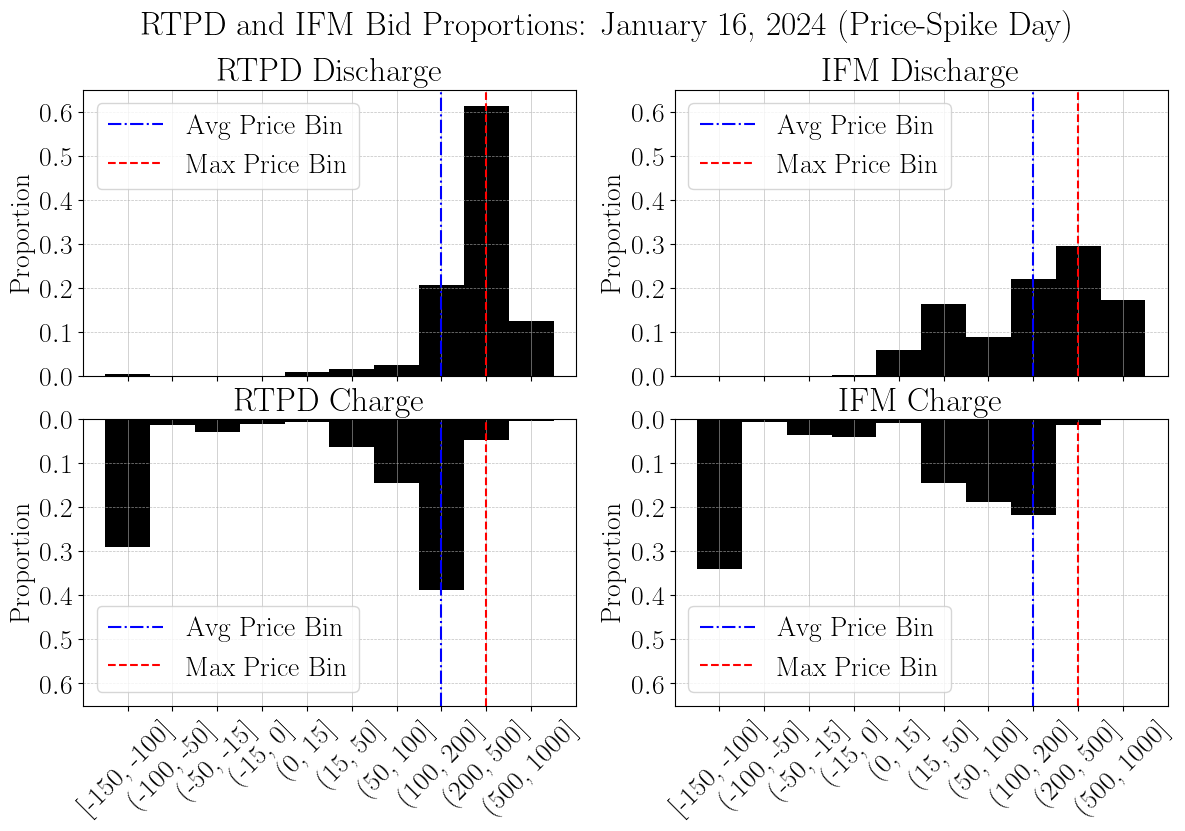

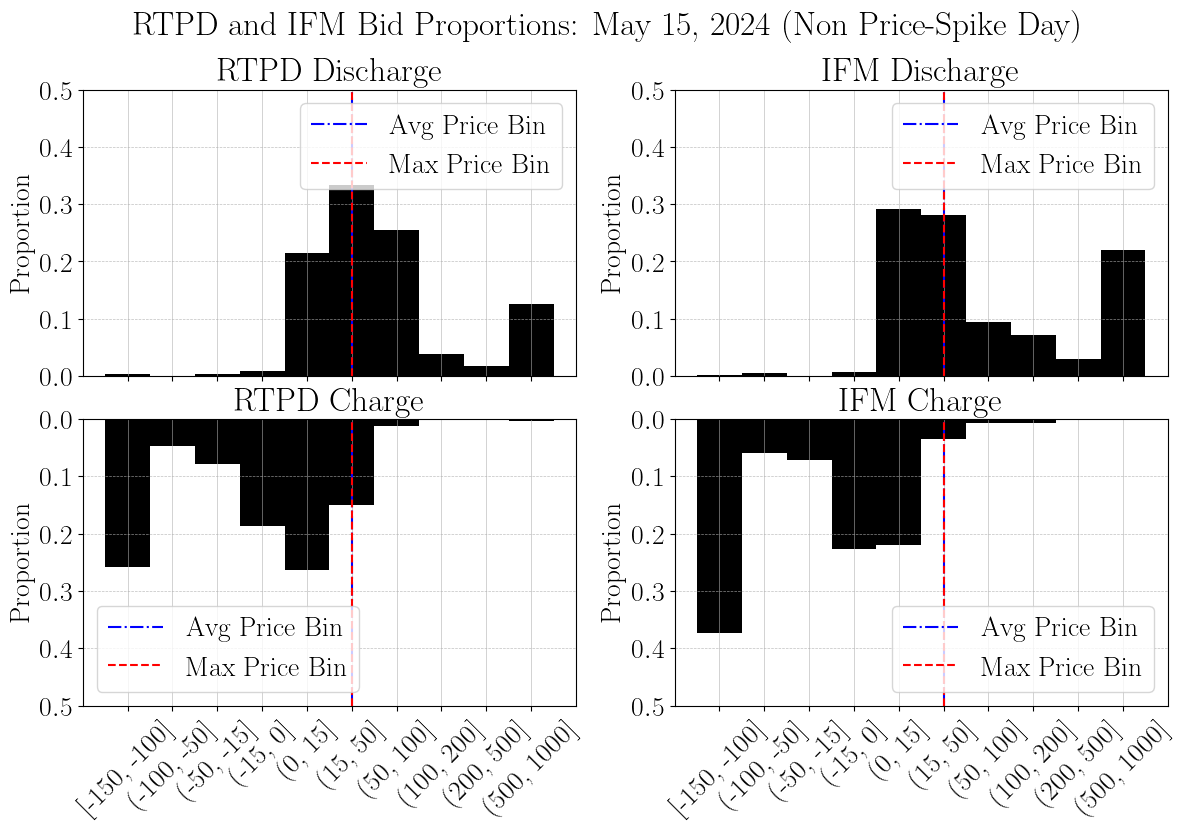

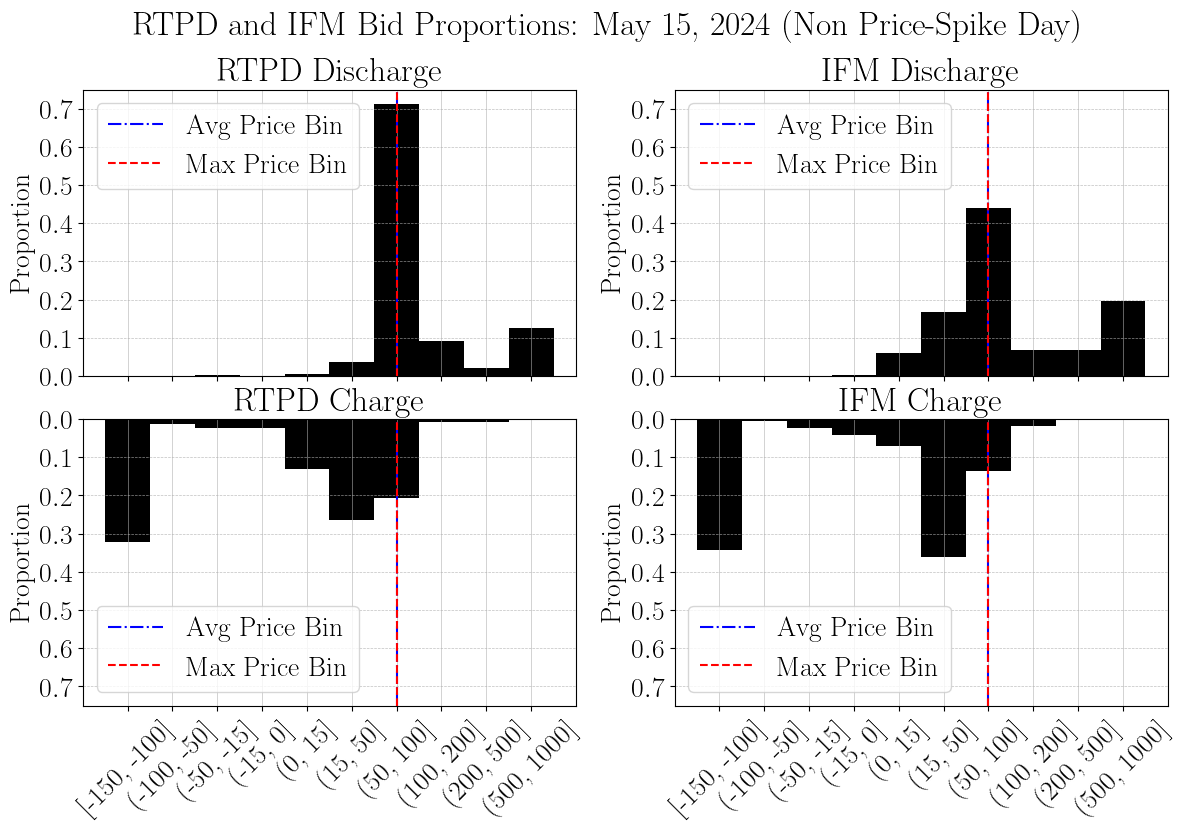

In [70]:
plot_bid_distribution(
    data=daily_df,
    start_date=pd.Timestamp("January 16, 2024"),
    end_date=pd.Timestamp("January 16, 2024"),
    date_descriptor="January 16, 2024 (Price-Spike Day)",
)

plot_bid_distribution(
    data=daily_df,
    start_date=pd.Timestamp("May 15, 2024"),
    end_date=pd.Timestamp("May 15, 2024"),
    date_descriptor="May 15, 2024 (Non Price-Spike Day)",
)

plot_bid_distribution(
    data=daily_df,
    start_date=pd.Timestamp("January 22, 2024"),
    end_date=pd.Timestamp("January 22, 2024"),
    date_descriptor="May 15, 2024 (Non Price-Spike Day)",
)

### Stacked Hourly Bid Distribution

In [71]:
def plot_stacked_hourly_bid_distribution(df, start_date, end_date):
    # Filter data between start_date and end_date
    df_filtered_hourly = df[(df.index >= start_date) & (df.index <= end_date)]

    # Resample data to hourly frequency
    df_hourly = df_filtered_hourly.resample("h").mean()

    # Extract hour of the day
    df_hourly["hour"] = df_hourly.index.hour

    # Define bid segment columns
    suffixes = ["ss"] + [str(i) for i in range(1, 12)]
    rtpd_pos_columns = [f"bid_rtpd_pos_{suffix}" for suffix in suffixes]
    rtpd_neg_columns = [f"bid_rtpd_neg_{suffix}" for suffix in suffixes]
    ifm_pos_columns = [f"bid_ifm_pos_{suffix}" for suffix in suffixes]
    ifm_neg_columns = [f"bid_ifm_neg_{suffix}" for suffix in suffixes]

    # Plot stacked distributions
    fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

    cmap_selection = "nipy_spectral"
    for ax in axs.flat:
        ax.set_ylim(0, 1)
    # RTPD Discharge bids
    df_hourly[rtpd_pos_columns].div(
        df_hourly[rtpd_pos_columns].sum(axis=1), axis=0
    ).plot(kind="bar", stacked=True, ax=axs[0, 0], width=1.0, colormap=cmap_selection)
    axs[0, 0].set_title("RTPD Discharge Bids")
    axs[0, 0].set_ylabel("Proportion")
    axs[0, 0].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)

    # RTPD Charge bids
    df_hourly[rtpd_neg_columns].div(
        df_hourly[rtpd_neg_columns].sum(axis=1), axis=0
    ).plot(kind="bar", stacked=True, ax=axs[1, 0], width=1.0, colormap=cmap_selection)
    axs[1, 0].set_title("RTPD Charge Bids")
    axs[1, 0].set_ylabel("Proportion")
    axs[1, 0].set_xlabel("Hour of the Day")
    axs[1, 0].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)

    # IFM Discharge bids
    df_hourly[ifm_pos_columns].div(df_hourly[ifm_pos_columns].sum(axis=1), axis=0).plot(
        kind="bar", stacked=True, ax=axs[0, 1], width=1.0, colormap=cmap_selection
    )
    axs[0, 1].set_title("IFM Discharge Bids")
    axs[0, 1].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)

    # IFM Charge bids
    df_hourly[ifm_neg_columns].div(df_hourly[ifm_neg_columns].sum(axis=1), axis=0).plot(
        kind="bar", stacked=True, ax=axs[1, 1], width=1.0, colormap=cmap_selection
    )
    axs[1, 1].set_title("IFM Charge Bids")
    axs[1, 1].set_xlabel("Hour of the Day")
    axs[1, 1].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)

    # Create a single legend
    handles, labels = axs[0, 0].get_legend_handles_labels()
    for ax in axs.flat:
        ax.legend().remove()
    legend_labels = [f"Segment: {bid_segments[suffix]}" for suffix in suffixes]
    fig.legend(handles, legend_labels, loc="center left", bbox_to_anchor=(1.0, 0.5))

    plt.tight_layout()
    plt.show()

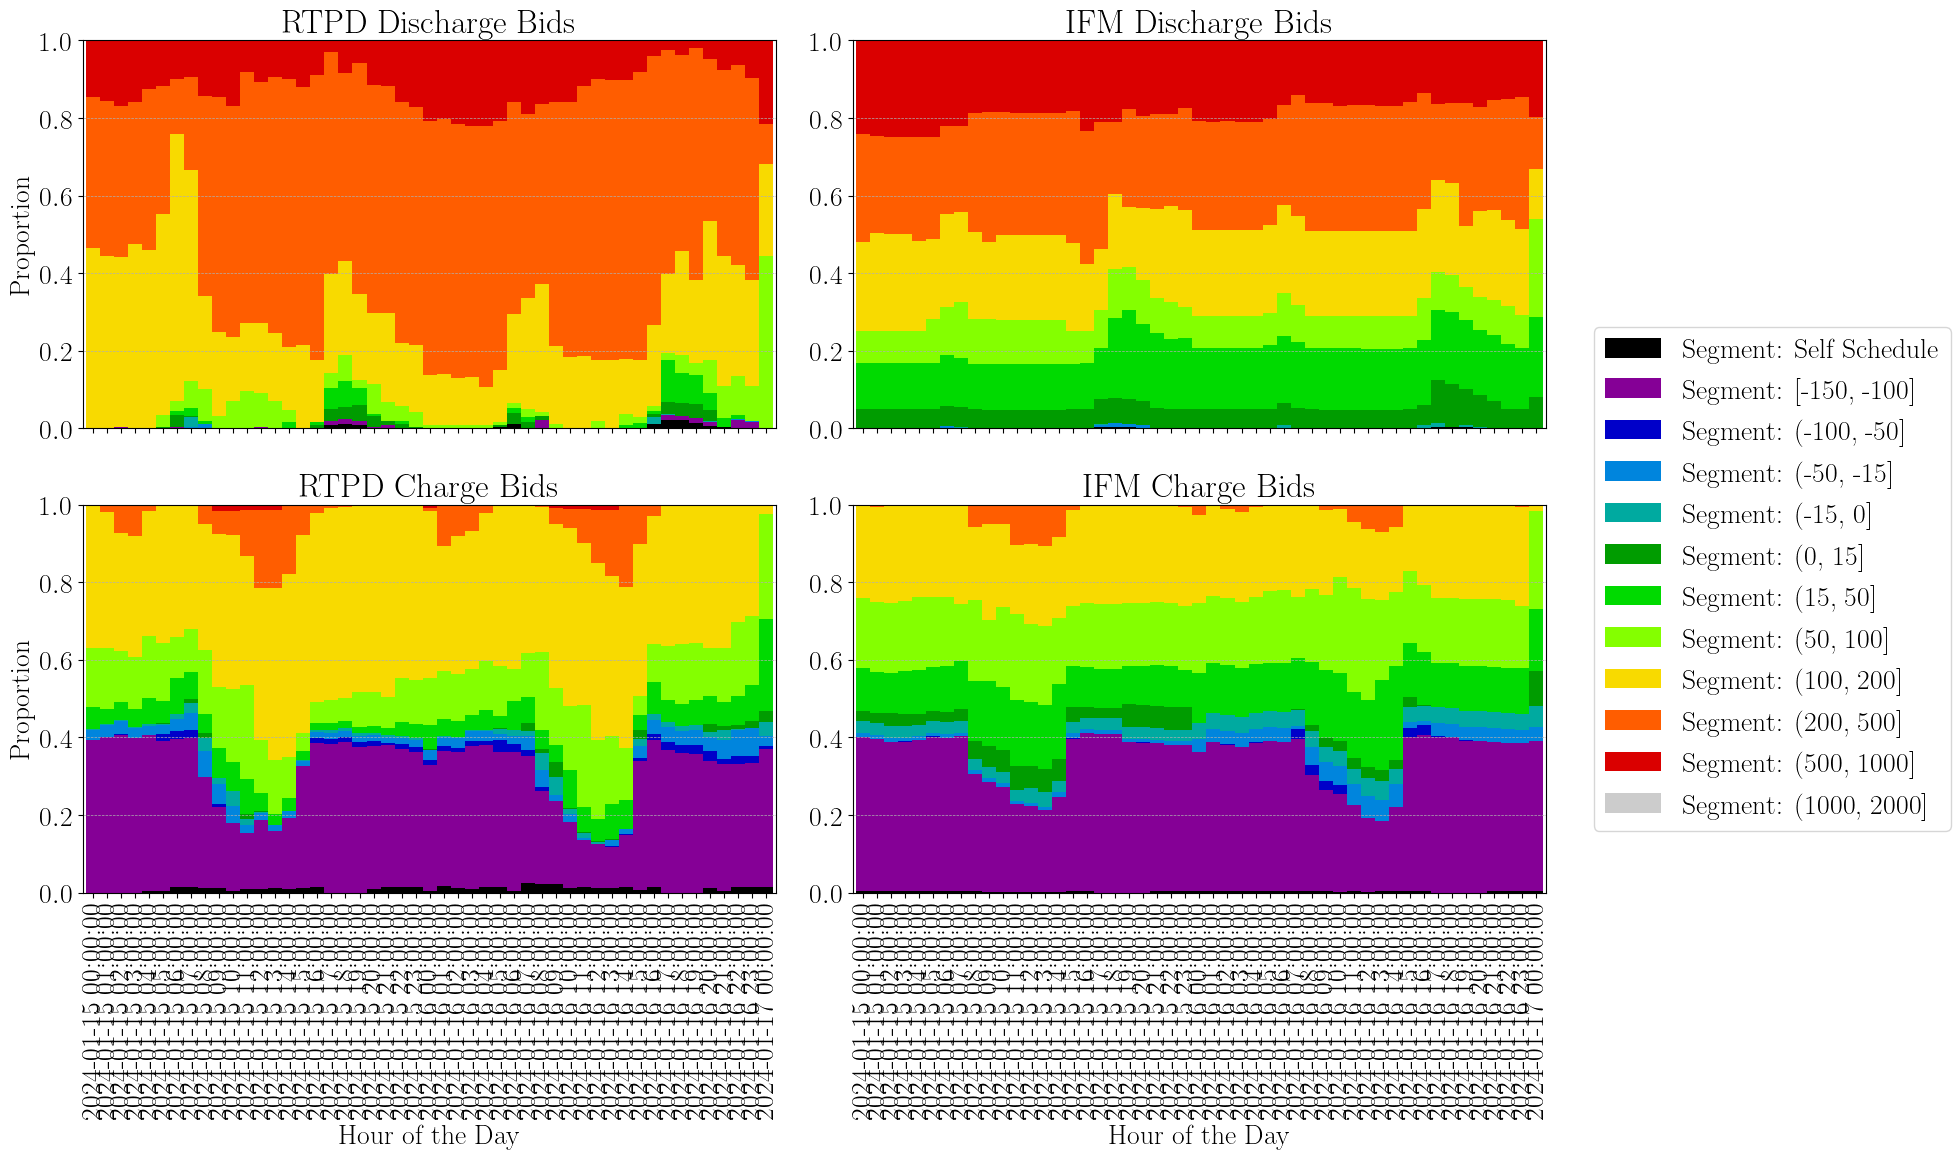

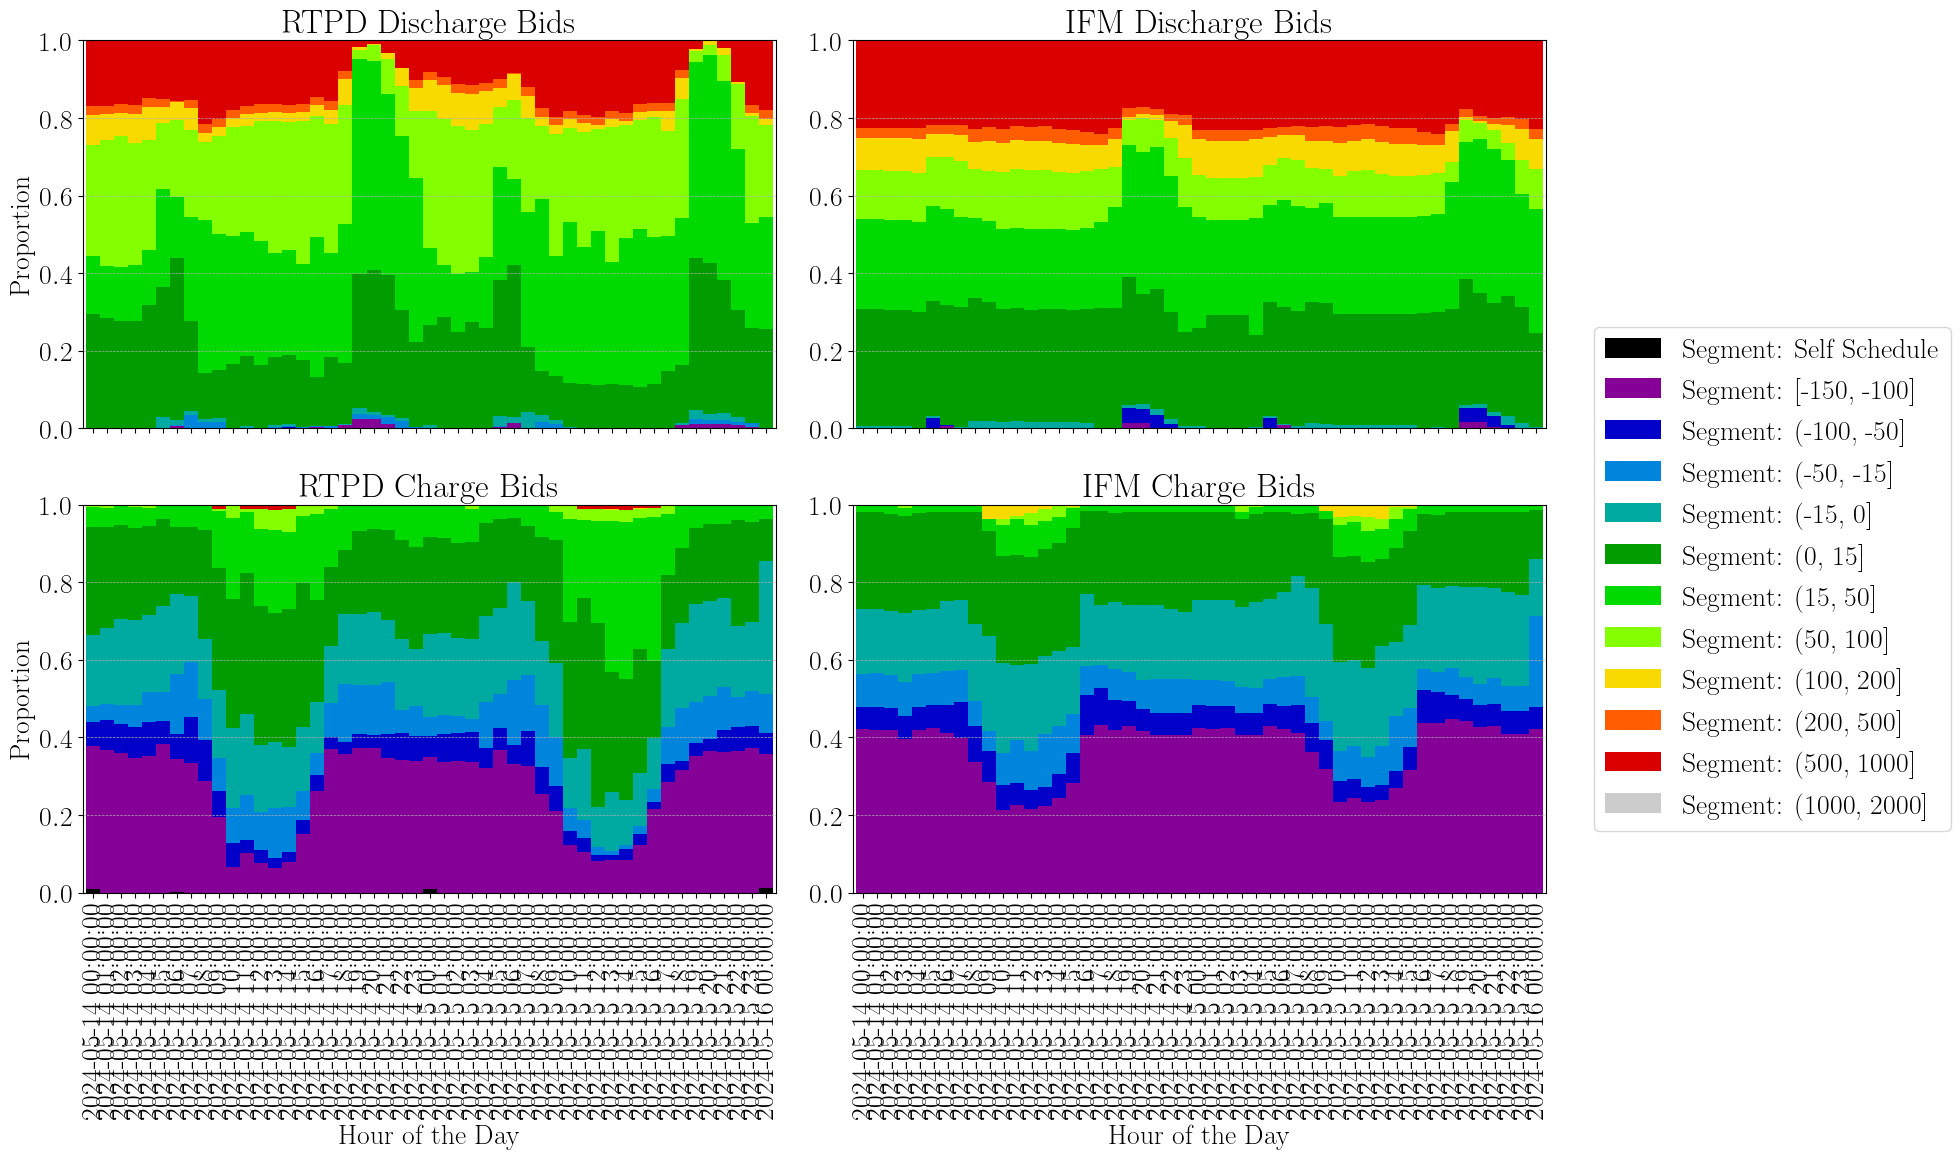

In [72]:
plot_stacked_hourly_bid_distribution(
    df=hourly_df,
    start_date=pd.Timestamp("January 15, 2024"),
    end_date=pd.Timestamp("January 17, 2024"),
)

plot_stacked_hourly_bid_distribution(
    df=hourly_df,
    start_date=pd.Timestamp("May 14, 2024"),
    end_date=pd.Timestamp("May 16, 2024"),
)